<a href="https://colab.research.google.com/github/trungdung1711/credit-card-fraud-detection/blob/feature%2Freimplementation/notebooks/_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# CREDIT CARD FRAUD DETECTION

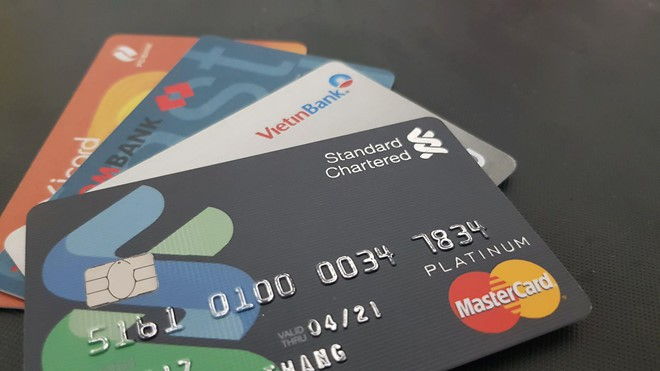

## 👀 REFERENCE LINKS
- `Dataset`: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- `Github`: https://github.com/trungdung1711/credit-card-fraud-detection
- `Useful resources`:
  - https://www.pointr.tech/blog/measuring-ai-mapping-performance
  - https://www.comet.com/site/blog/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning/
  - https://www.mastersindatascience.org/learning/statistics-data-science/undersampling/
  - https://www.kaggle.com/discussions/general/424515
  - https://www.kaggle.com/discussions/general/424270
  - https://machinelearningcoban.com/2017/01/01/kmeans/



---



## 📚 MODULES AND PACKAGES

In [1]:
! pip install thundersvm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.4/507.4 kB 11.0 MB/s eta 0:00:00


In [8]:
# maths
import pandas as pd
import numpy as np
import random

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# data splitting and pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans

# classification metrics
from sklearn.metrics import (
      make_scorer,
      precision_score,
      recall_score,
      f1_score,
      fbeta_score,
      roc_auc_score,
      classification_report,
      confusion_matrix,
      accuracy_score
    )

# undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids

# oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB



---



## 🚙 UTILITIES

In [3]:
def print_df(df):
    with pd.option_context("display.max_columns", None):
        display(df.head(2))

def random_color():
    return "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))

def fpr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def collect_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  f2 = fbeta_score(y_true, y_pred, beta=2)
  fpr = fpr_score(y_true, y_pred)
  auc = roc_auc_score(y_true, y_pred)

  return [
      accuracy,
      precision,
      recall,
      f1,
      f2,
      fpr,
      auc
  ]



---



## 👇🏻 DATASET DOWNLOADING

In [4]:
! curl -L -o ./creditcardfraud.zip https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud
! mkdir ./data
! unzip ./creditcardfraud.zip -d ./data
! rm ./creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  46.6M      0  0:00:01  0:00:01 --:--:--  104M
Archive:  ./creditcardfraud.zip
  inflating: ./data/creditcard.csv   


In [5]:
df = pd.read_csv("./data/creditcard.csv")
print_df(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0




---



## 🔢 CONSTANTS



---



## 🔍 EXPLORATORY DATA ANALYSIS

**Basic information**:
- The dataset contains transactions in September 2013 by European cardholders.
- This dataset contains transactions in two days, where we have 492/284,807 fraud transactions



---



In [ ]:
eda_df = df.copy(deep=True)

**What is the class distribution of the dataset?**

In [ ]:
eda_df["Class"].value_counts()

,count
Class,
0,284315
1,492


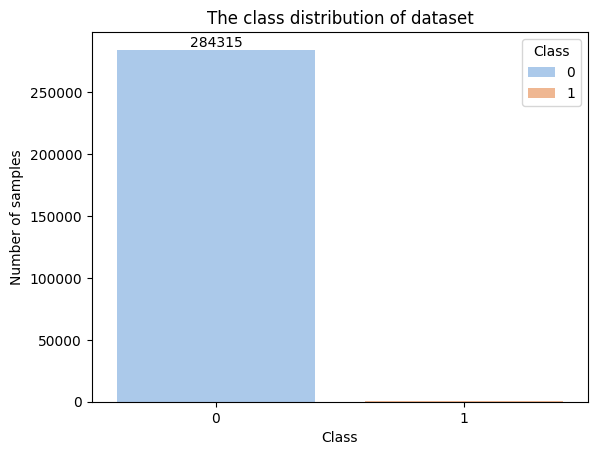

In [ ]:
ax = sns.countplot(data=eda_df, x="Class", hue="Class", palette="pastel")
ax.bar_label(ax.containers[0])

plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("The class distribution of dataset")
plt.show()

**NOTE**: The dataset is highly imbalanced, as the number of non-fraud transaction is 284315 while the number of fraud transaction only accounts for 492 (0.0172%)

**What do time gaps between transanctions on 2 days look like?**

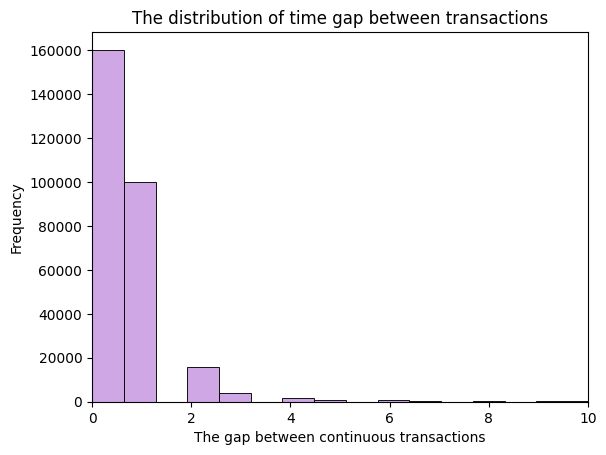

In [ ]:
eda_df.sort_values("Time")
eda_df["time_diff"] = eda_df["Time"].diff()

sns.histplot(data=eda_df, x="time_diff", color=random_color(), bins=50)

plt.xlim((0, 10))
plt.xlabel("The gap between continuous transactions")
plt.ylabel("Frequency")
plt.title("The distribution of time gap between transactions")
plt.show()

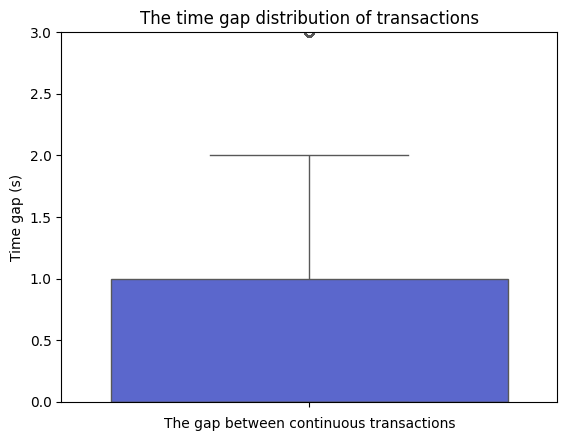

In [ ]:
sns.boxplot(data=eda_df, y="time_diff", color=random_color())

plt.ylim((0, 3))
plt.xlabel("The gap between continuous transactions")
plt.ylabel("Time gap (s)")
plt.title("The time gap distribution of transactions")
plt.show()

**NOTE**: Most of the gaps are 0 or 1, and 2, meaning that after a transaction, the next transaction would likely to occur in 1.0 or 2.0 seconds

**What are the number of transactions as the time goes?**

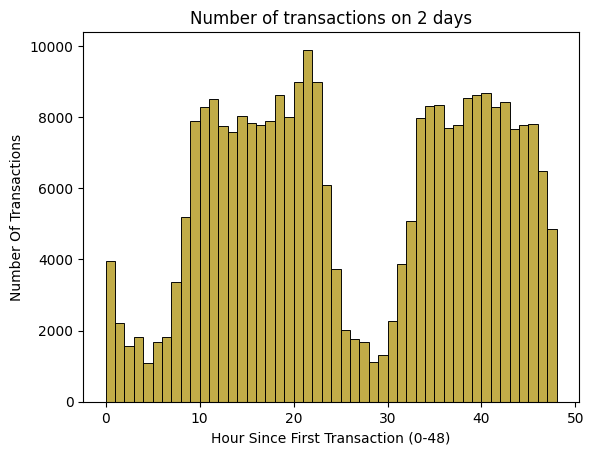

In [ ]:
eda_df['hour'] = eda_df['Time'] / 3600

sns.histplot(data=eda_df, x='hour', bins=48, kde=False, color=random_color())
plt.title('Number of transactions on 2 days')
plt.xlabel('Hour Since First Transaction (0-48)')
plt.ylabel("Number Of Transactions")
plt.show()


**NOTE**: It is likely the transactions are recorded from 00:00 (day 1) to 23:59 (day 2), because the number of transactions at the time near midnight seems to decrease significantly, while during the daytime, afternoon, and evening (from 8:00 am to 8:00 pm), the number of transactions seems to remain stable at high frequency (repeating pattern of day 1 and day 2, around 8000 transactions per hour). This makes perfect real world sense

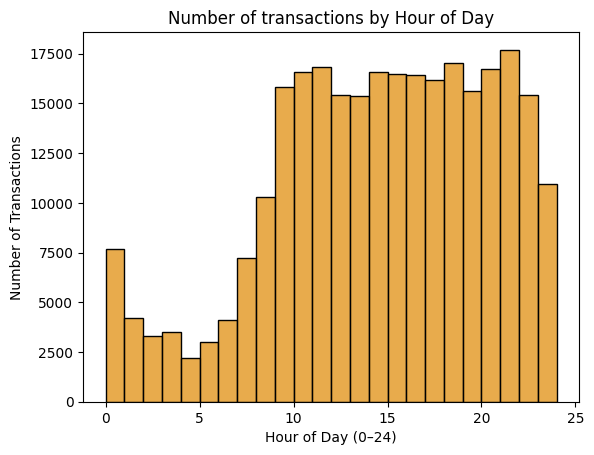

In [ ]:
# folds both day together
df['hour_in_day'] = (df['Time'] / 3600) % 24

sns.histplot(df['hour_in_day'], bins=24, color=random_color())
plt.title('Number of transactions by Hour of Day')
plt.xlabel('Hour of Day (0–24)')
plt.ylabel('Number of Transactions')
plt.show()


**Given the class of `fraudulent`, what are the times such that those fraudulent operations usually occur?**

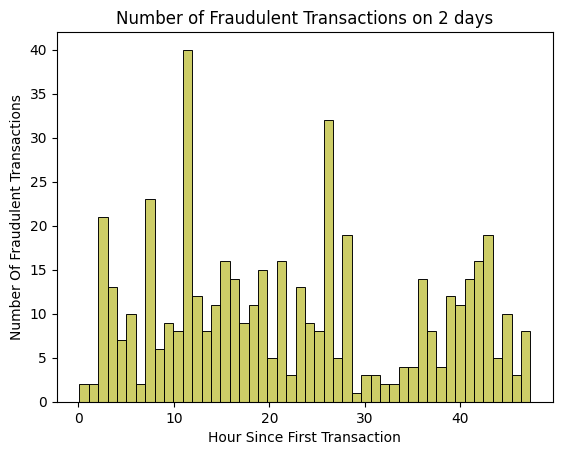

In [ ]:
sns.histplot(data=eda_df[eda_df["Class"] == 1], x="hour", bins=48, kde=False, color=random_color())

plt.xlabel("Hour Since First Transaction")
plt.ylabel("Number Of Fraudulent Transactions")
plt.title("Number of Fraudulent Transactions on 2 days")
plt.show()

**What is the transaction distribution by `Amount`?**

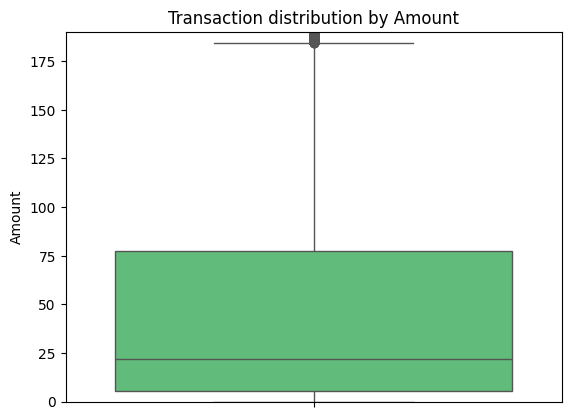

In [ ]:
sns.boxplot(data=eda_df, y="Amount", color=random_color())

plt.ylim((0, 190))
plt.ylabel("Amount")
plt.title("Transaction distribution by Amount")
plt.show()

**Given the classes (`normal` and `fraudulent`) transaction, what are the transaction distribution by `Amount`?**

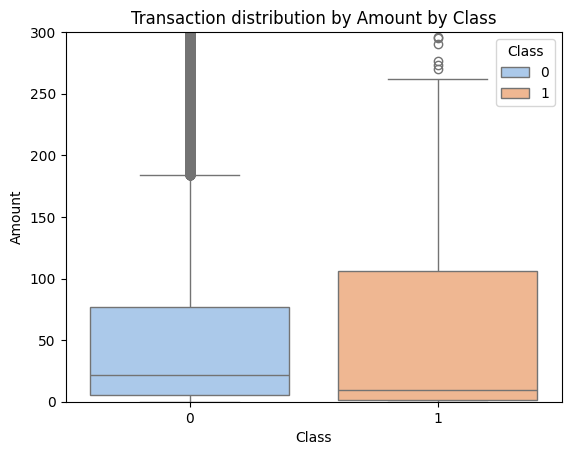

In [ ]:
sns.boxplot(data=eda_df, y="Amount", x="Class", palette="pastel", hue="Class")

plt.ylim((0, 300))
plt.title("Transaction distribution by Amount by Class")
plt.ylabel("Amount")
plt.show()

**NOTE**: Given the class (`normal` or `fraudulent`), we can notice that it seems that there is not a huge difference between the `Amount` in 2 types of transactions, in fact, most of the `Amount` of the transactions of the 2 classes, range mostly from 0 to 100$

**What is the `Amount` over times (`Class` separation)?**

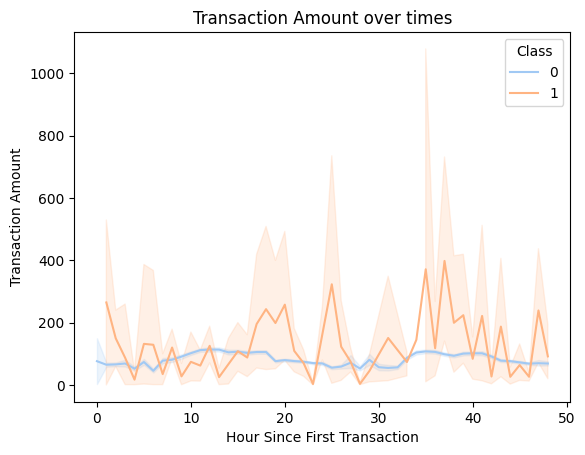

In [ ]:
eda_df["hour_bin"] = np.ceil(eda_df["hour"]).astype(int)
sns.lineplot(data=eda_df, x="hour_bin", y="Amount", estimator="mean", hue="Class", palette="pastel")

plt.xlabel("Hour Since First Transaction")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount over times")
plt.legend(title="Class")
plt.show()

**NOTE**: It is explitcitly shown that over time, the `Amount`s of `Fraudulent` transactions are usually higher than `Normal` transactions'. Besides, there is a huge variance on the `Amount` in each hour, but `Normal` transactions' `Amount` keeps a consistent value as time passes. That strengthens the fact that `Amount`s in `Fraudulent` transactions are not always at a high value, but ranging in different values.

**What is the heatmap representing correlation between variables from V1 to V28?**

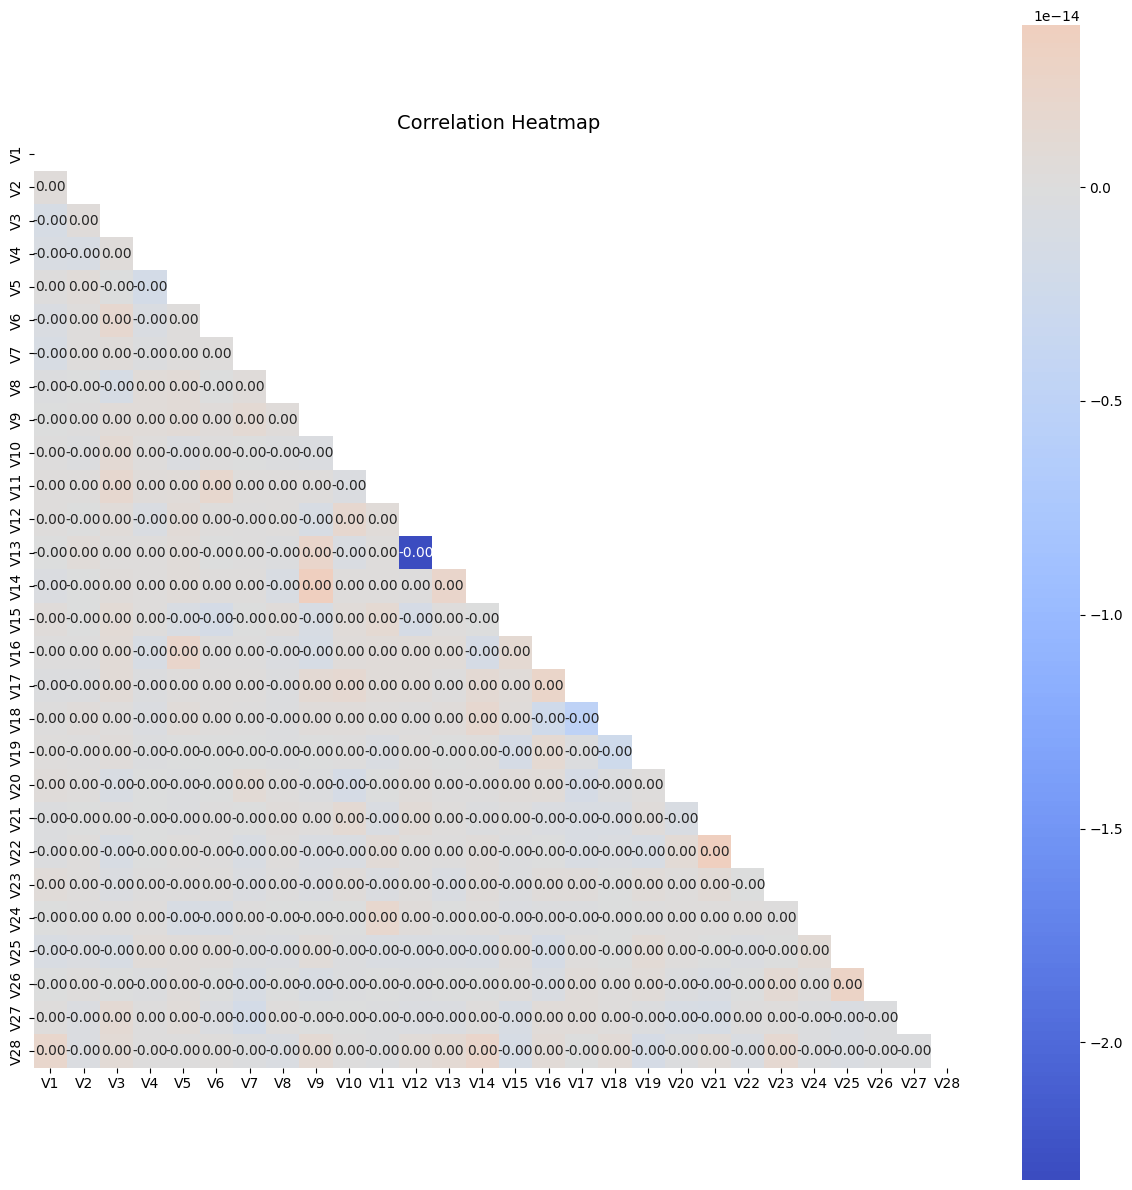

In [ ]:

corr = eda_df.drop(columns=["Time", "Amount", "Class", "time_diff", "hour", "hour_bin",]).corr(numeric_only=True)

plt.figure(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    square=True,
    mask=mask
)

plt.title("Correlation Heatmap", fontsize=14)
plt.show()


**NOTE**: Notice that most of the correlation coefficient values are 0.0, which is expected as the data was transformed using PCA technique, which produces features that are uncorrelated to each other (axis orthogonal to each other)

**Given the class, what are the feature distributions (V1-V28)?**

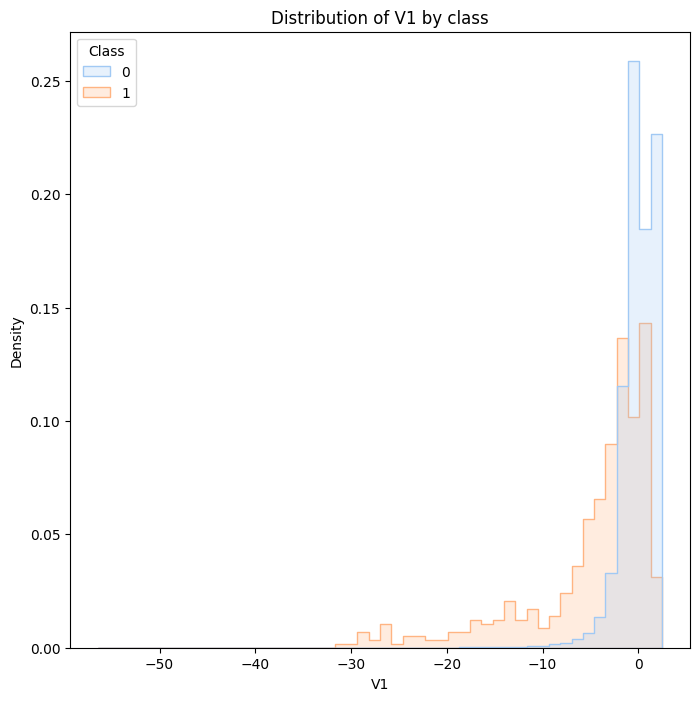

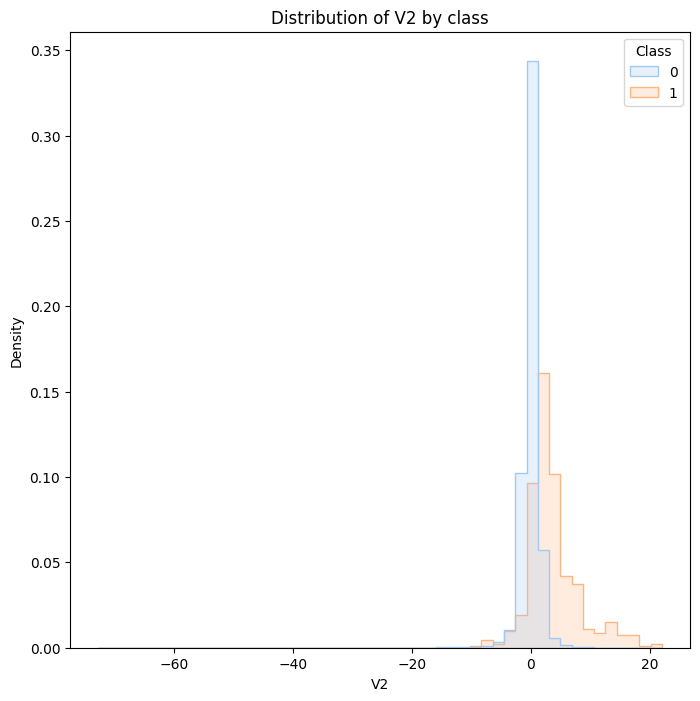

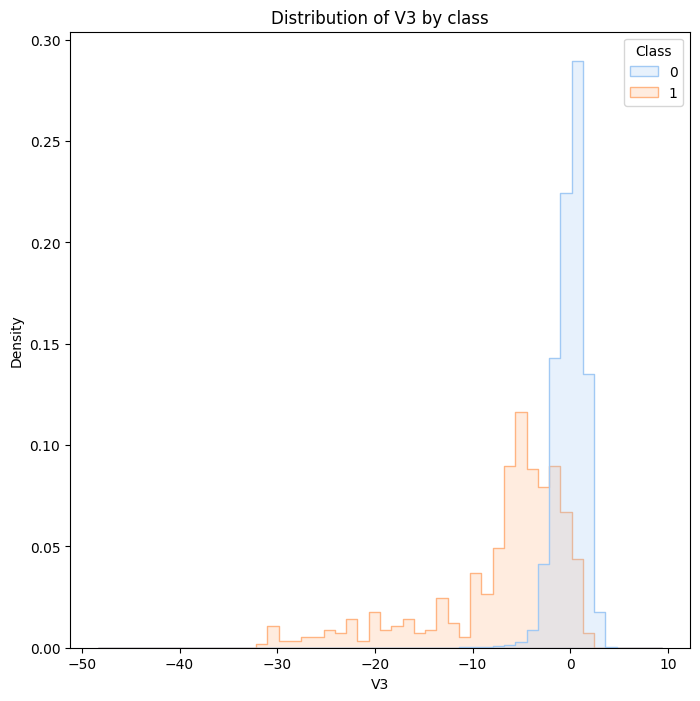

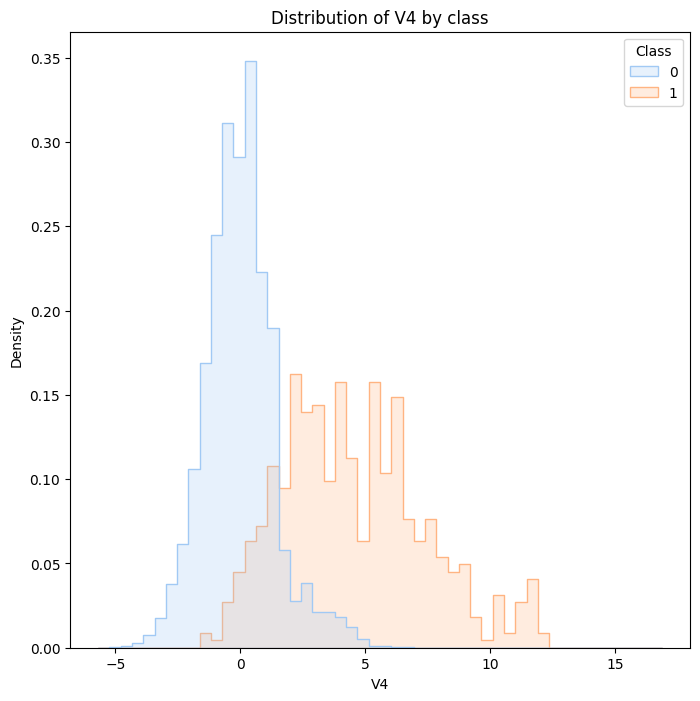

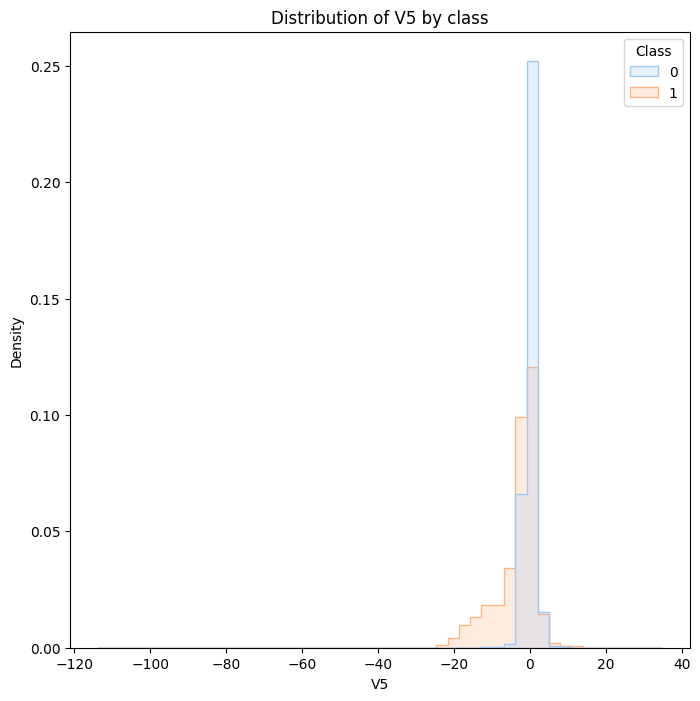

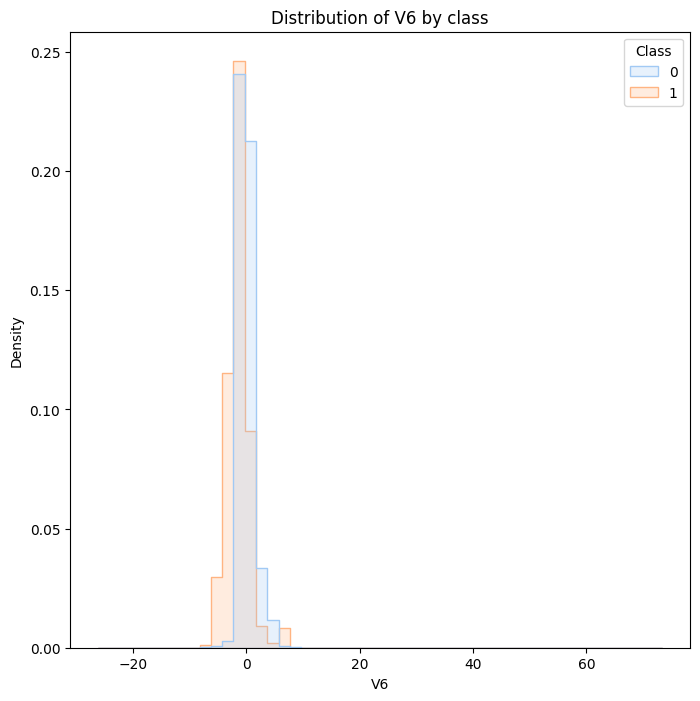

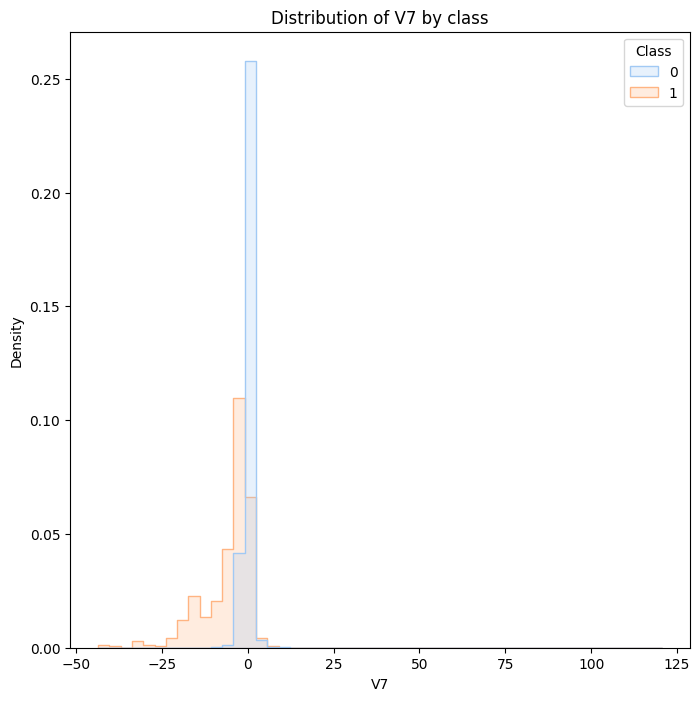

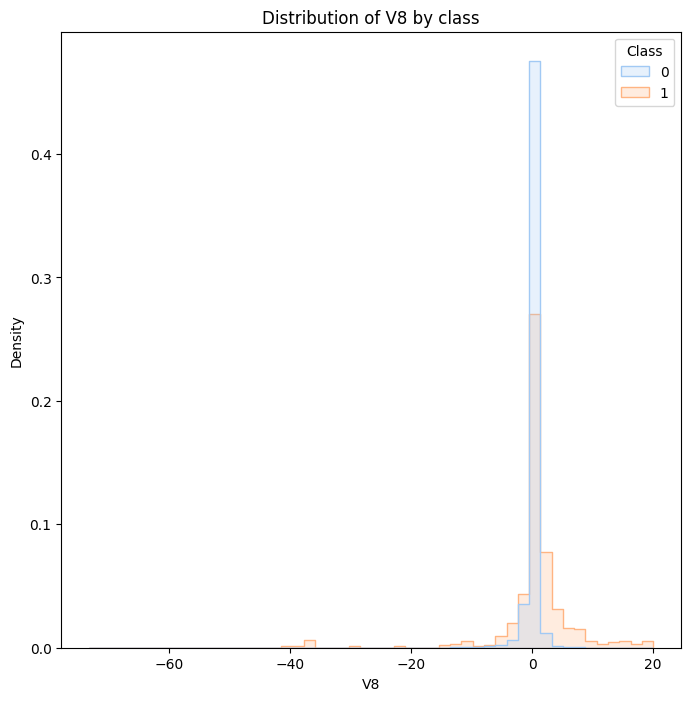

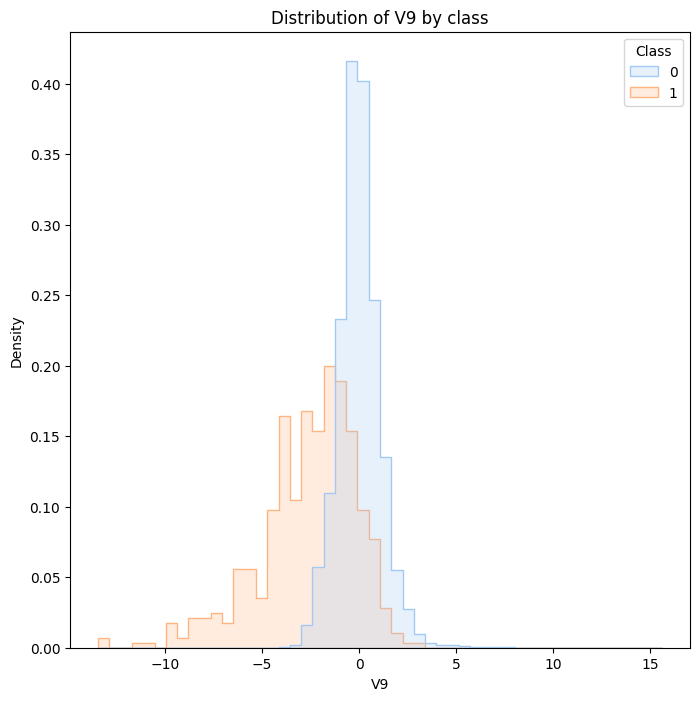

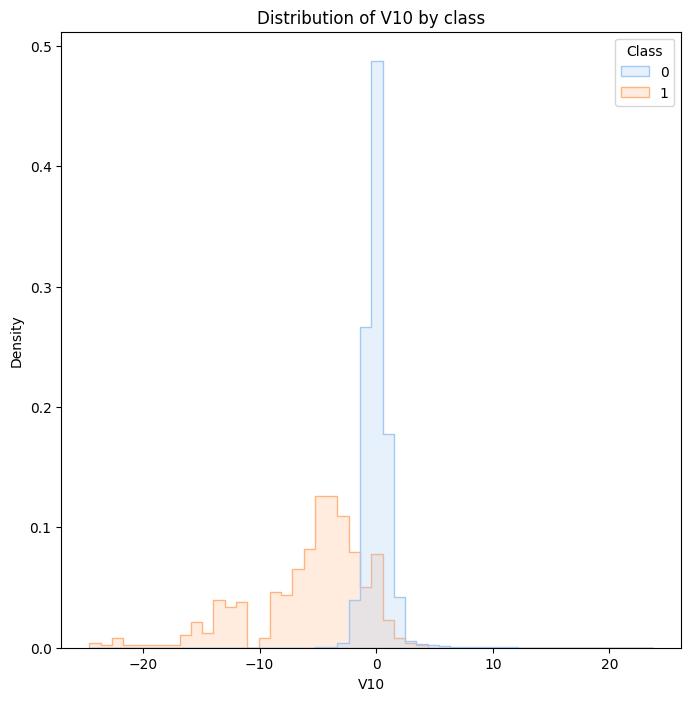

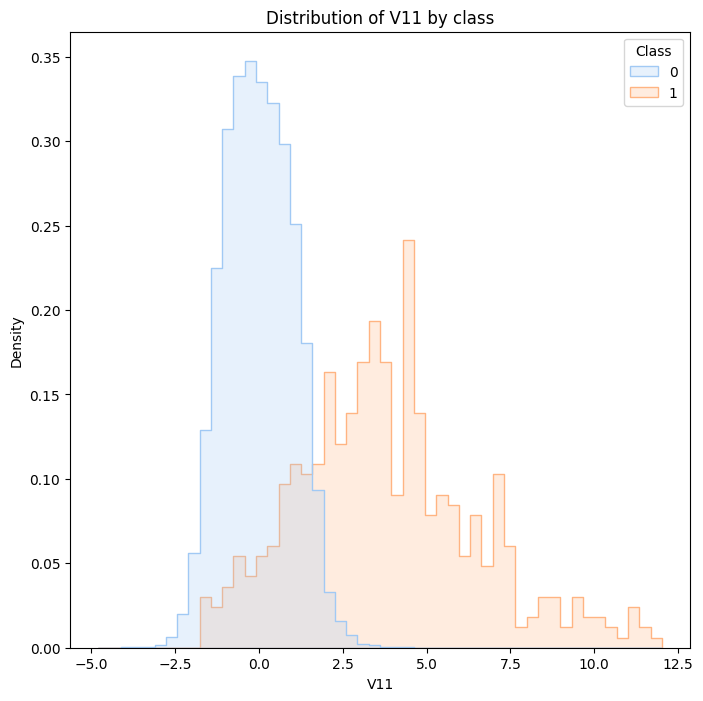

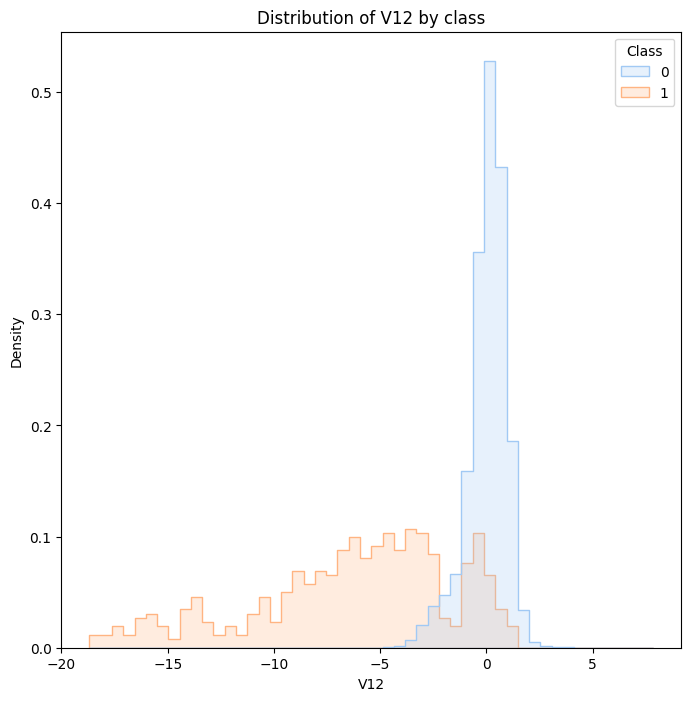

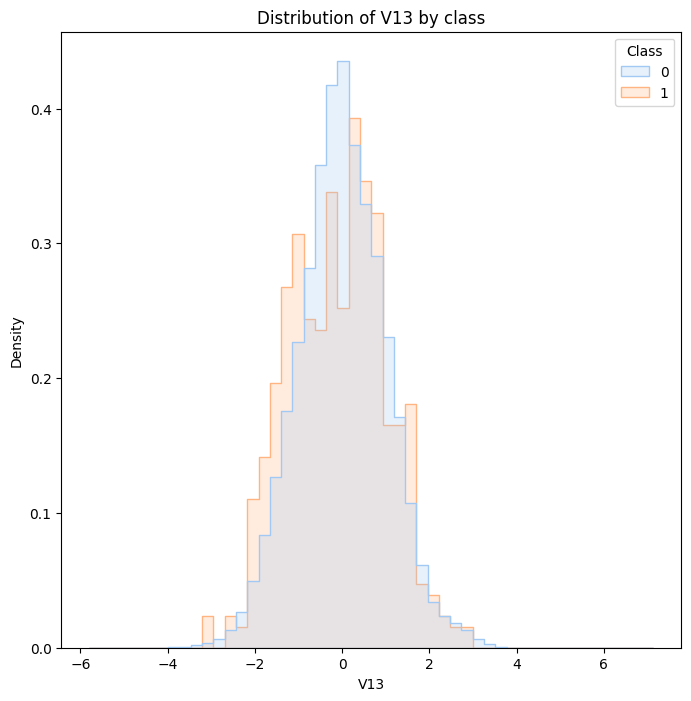

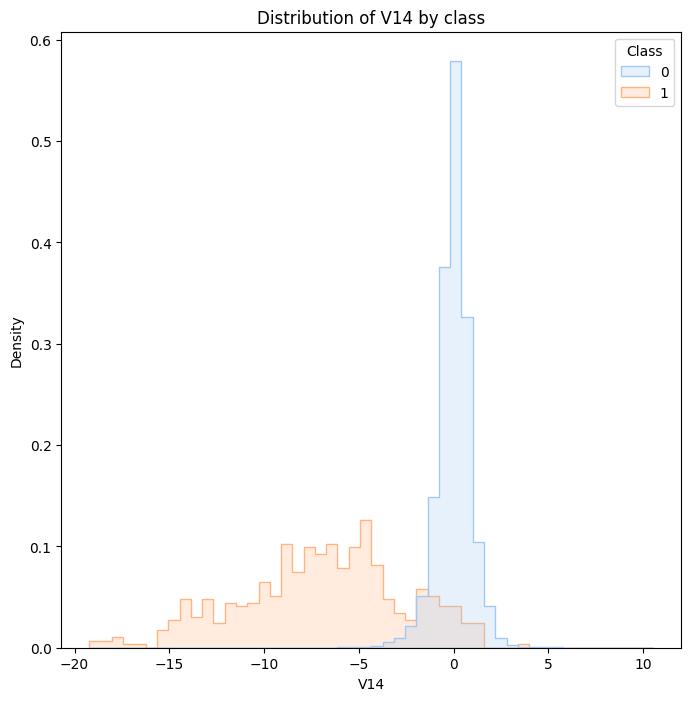

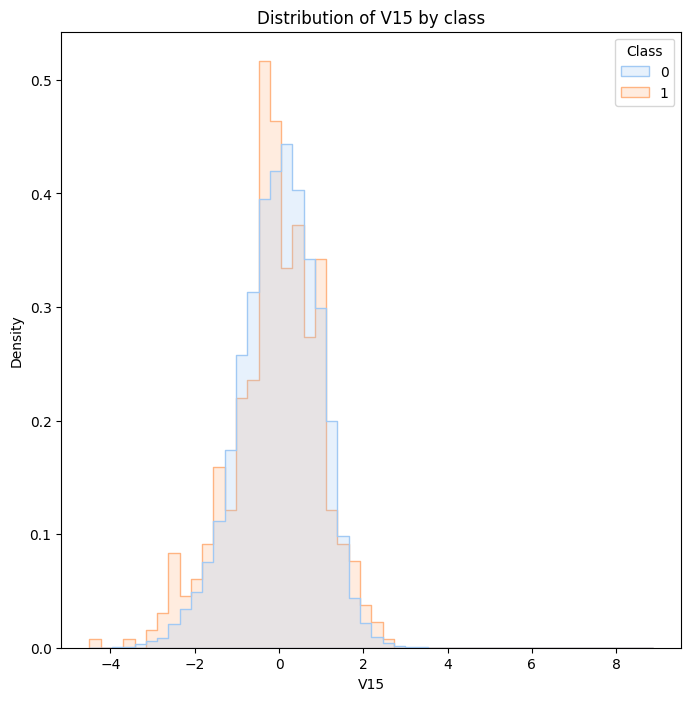

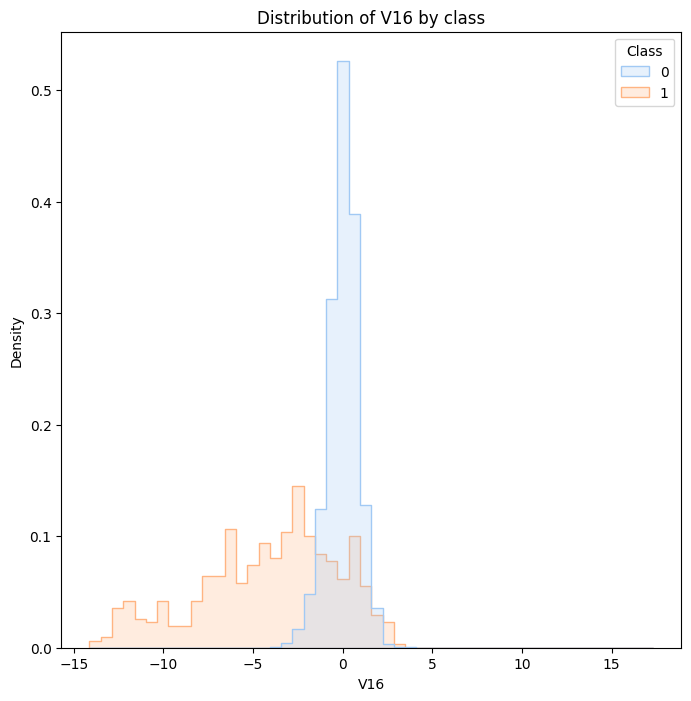

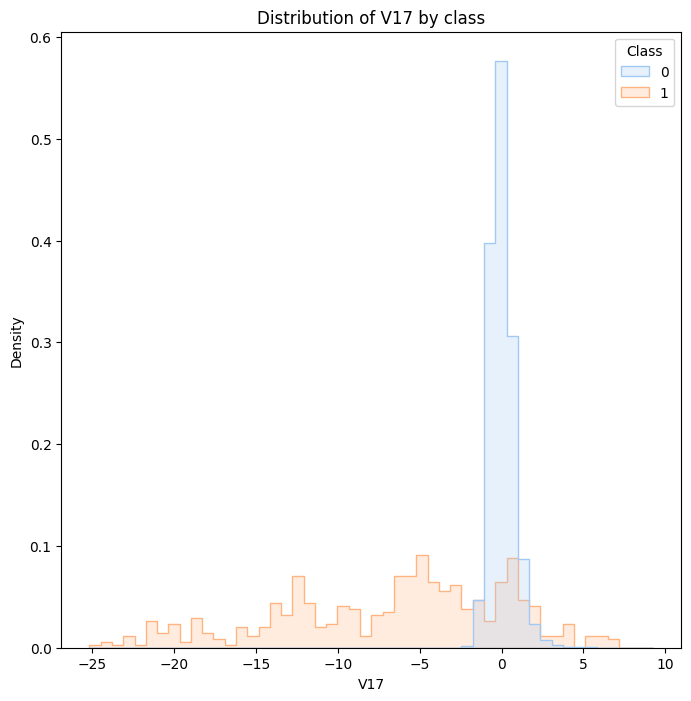

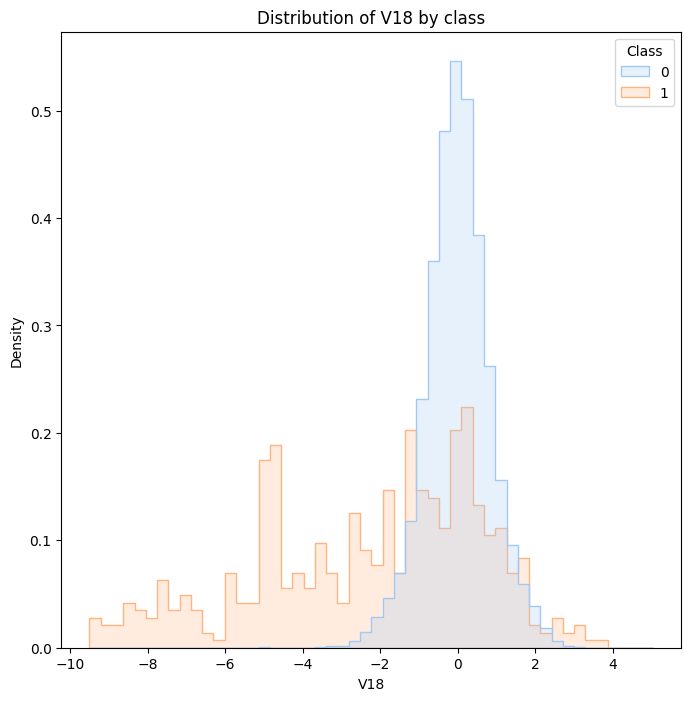

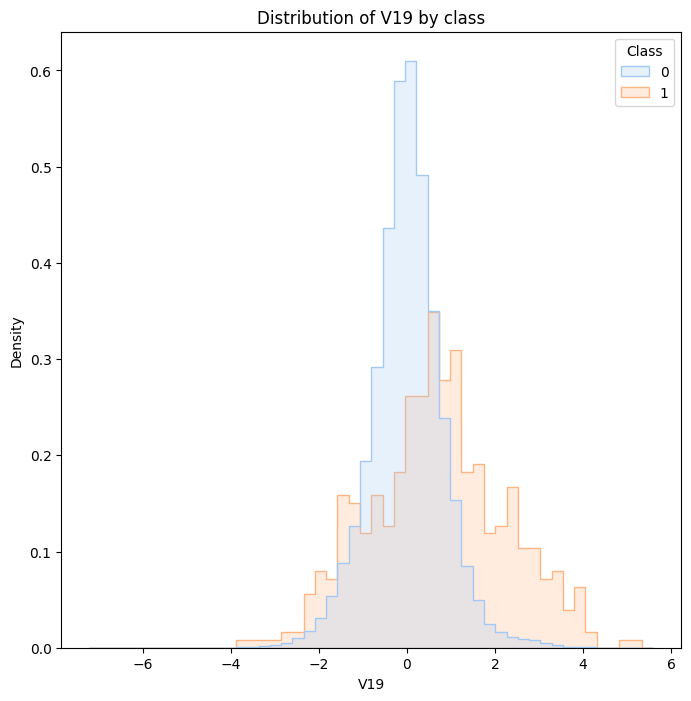

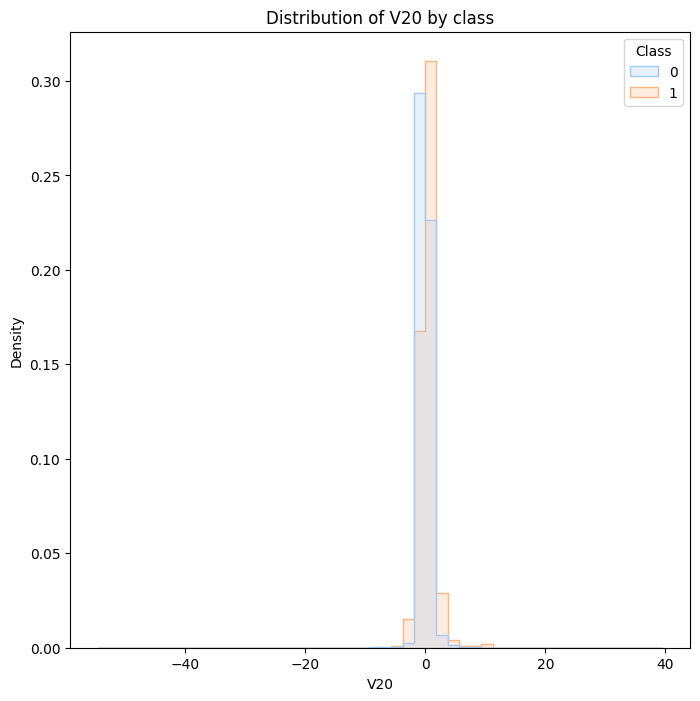

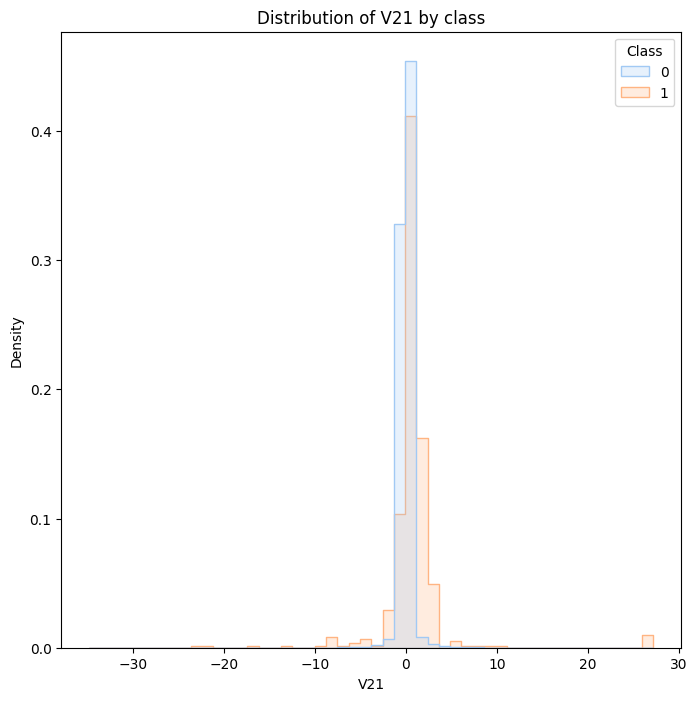

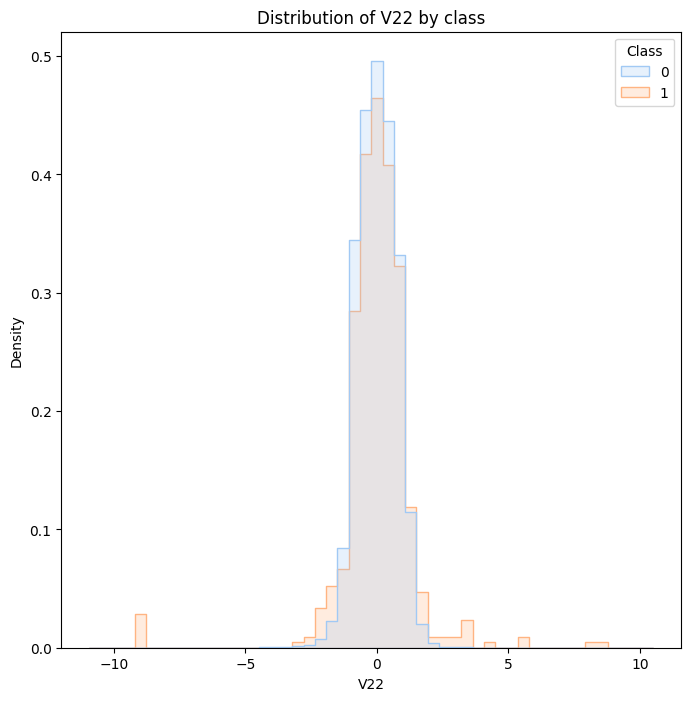

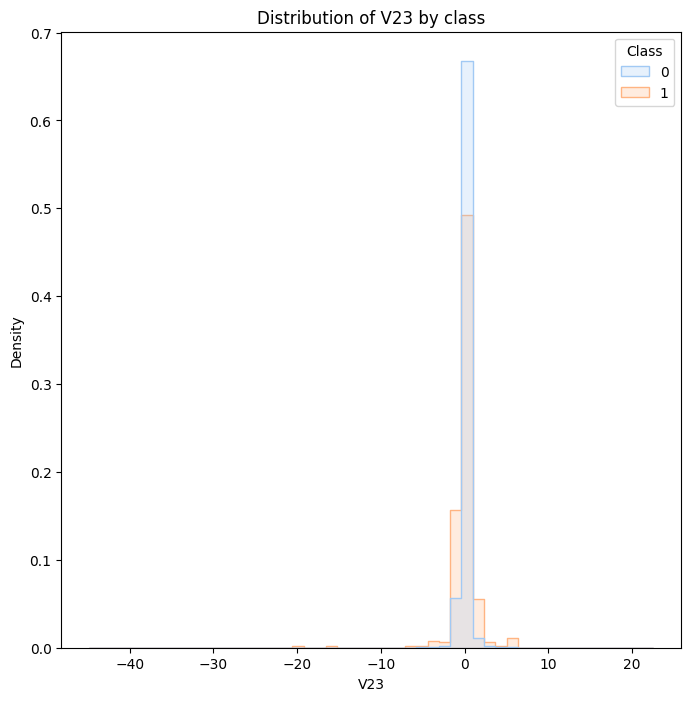

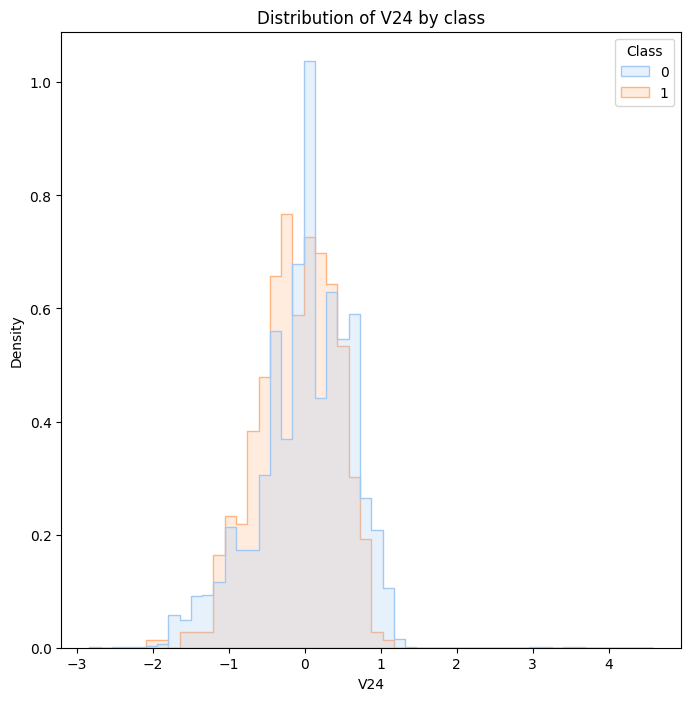

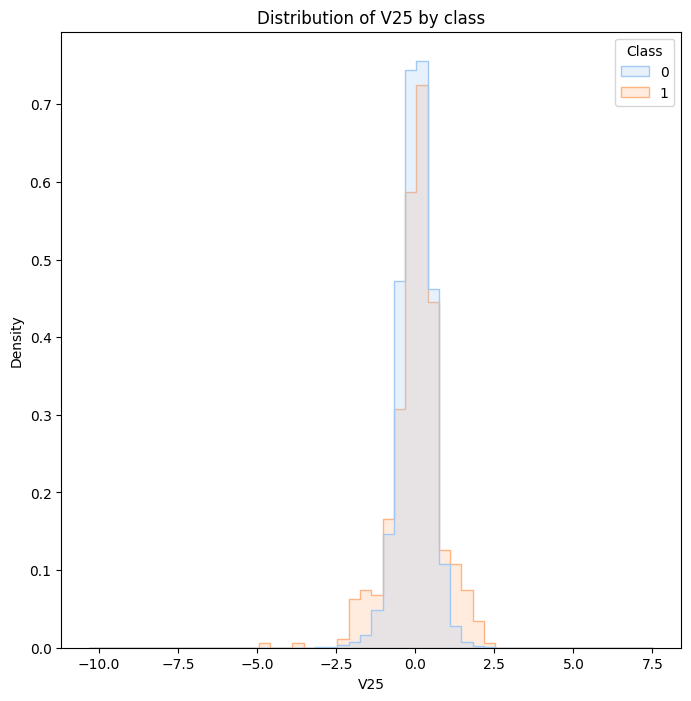

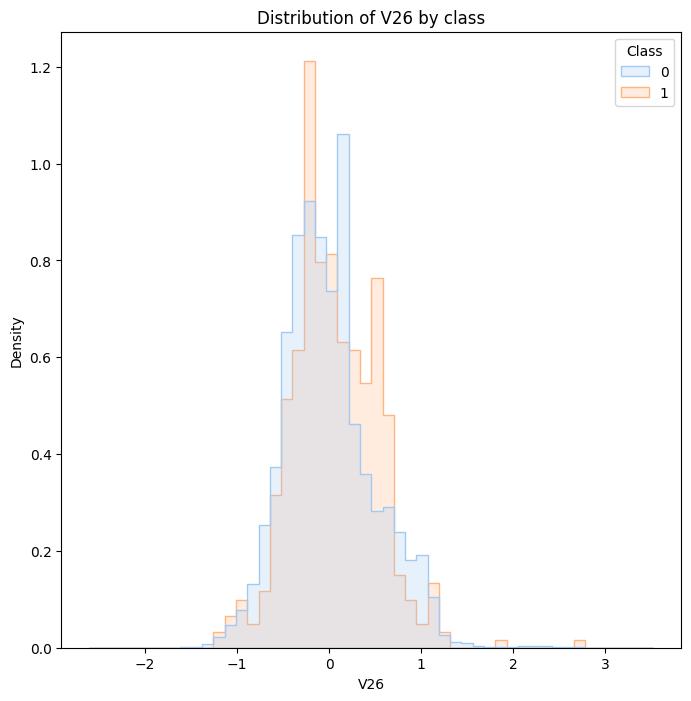

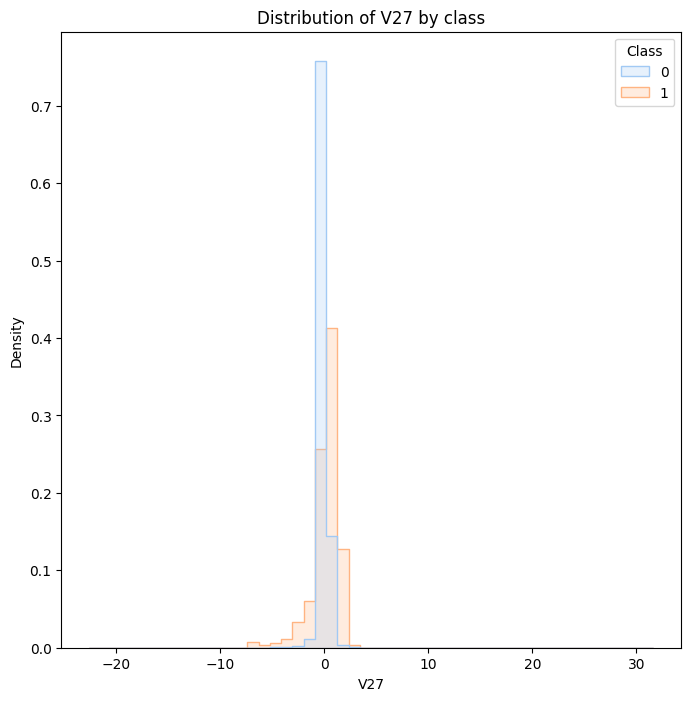

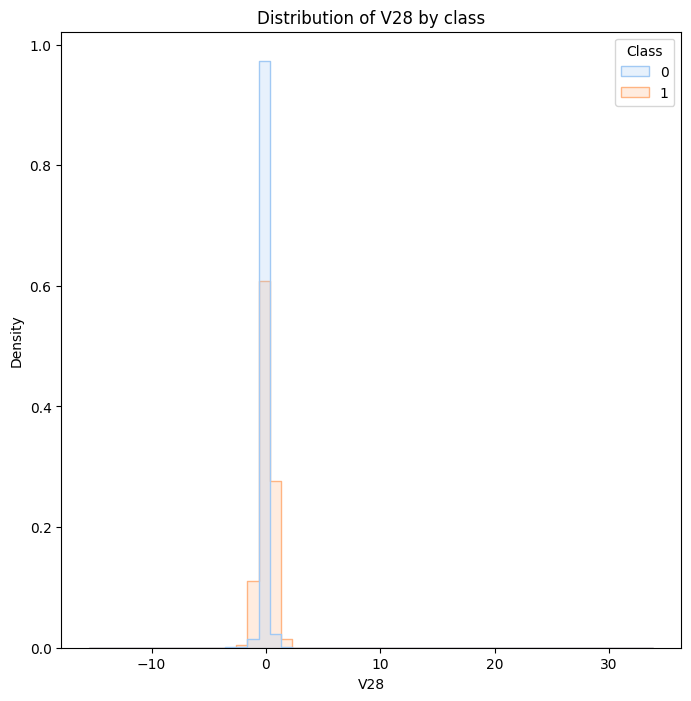

In [ ]:
for i in range(1, 29):
  plt.figure(figsize=(8, 8))
  sns.histplot(
      data=eda_df,
      x=f"V{i}",
      hue="Class",
      bins=50,
      element="step",
      stat="density",
      palette="pastel",
      common_norm=False   # normalize each class separately
  )

  plt.title(f"Distribution of V{i} by class")
  plt.show()


**NOTE**: Knowing the class, `V4`, `V11` has nearly different probability distributions, while `V15`, `V19`, `V22`, `V24`, `V25`, `V26`, `V27`, `V28` actually have similar probability. In the case of similar probability, when using those features (in Naive Bayes), given those features, it doesn't provide much information to the posterior probability (because the two P(X | class_i) would nearly be the same, the posterior probability would depend on the prior probability

**What is the scatter plot of PC1 and PC2 (V1, V2), ignoring information about other variables?**

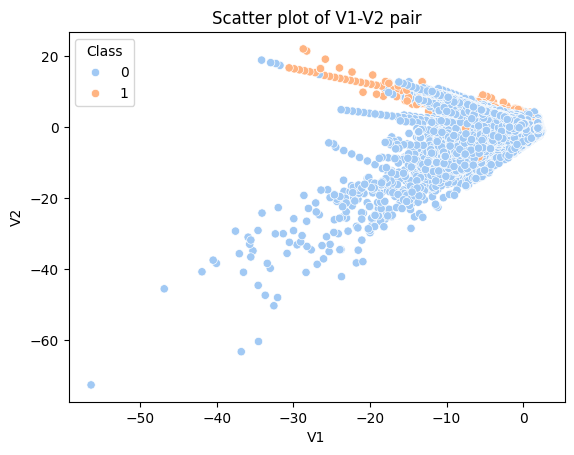

In [ ]:
sns.scatterplot(data=eda_df, x="V1", y="V2", hue="Class", palette="pastel")

plt.title("Scatter plot of V1-V2 pair")
plt.show()



---



## 🧑‍💻 MODEL TRANINING

### 🍴 Data preparation and splitting

In [8]:
# drop Time because it is an irrelevant features
df = df.drop(columns=["Time"])

In [9]:
X = df.drop(columns=["Class"])
y = df["Class"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# Class distribution
print("- ORIGINAL:\n", y.value_counts(normalize=True))
print("\n- TRAIN:\n", y_train.value_counts(normalize=True))
print("\n- TEST:\n", y_test.value_counts(normalize=True))

- ORIGINAL:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

- TRAIN:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

- TEST:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


### 🔎 Choosing which metric to pursue

**NOTE**: Which metric to pursue?
- `Accuracy`: misleading - dominated by majority class (non-fraud)
- `Precision`: High precision, fewer false alarms, low precision then when the model shouts fraud, it is usually a false positive one, which requires investigation
- `Recall`: High recall, fewer missed frauds (false negative), less financial loss
- `F1`: Balances between catching as many as possible frauds and limiting false alarms
- `F-beta`: Depend on beta, to weight `recall` or `precision` more than the other

---

In this case of `CREDIT CARD FRAUD DETECTION`, we decided to use the `F2` as our main metric for the model, that is because we want our model to catch as many as possible fraud transactions, but also want our model to have an enough value for precision (because very low precision can make the alerts untrustworthy, and this would require `fraud prevention team` to perform further investigation which takes times and resources and also harms customer experience. But we also want to favour `recall` more than `precision` (`False Negative` >> `False Positive`), because generally, missing an actual frauds would be considered more costly than a false alarms (missing frauds could affect bank's financial status, ...). Thus `F2` is chosen as the core metric here

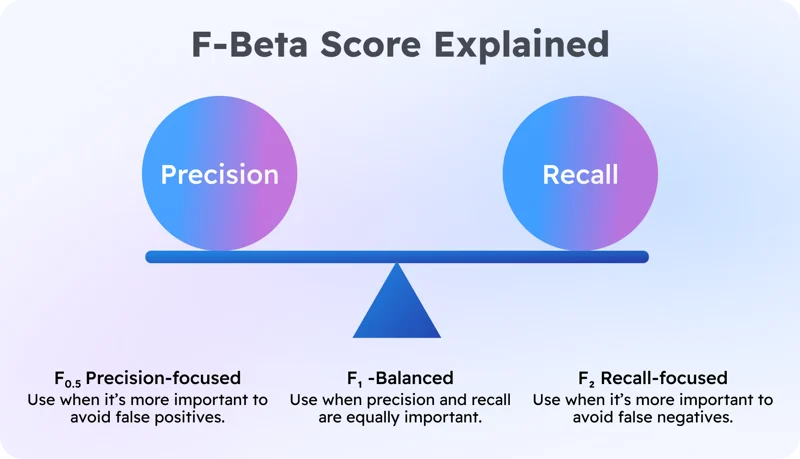

### 💩 Baseline with `Support vector machine`

##### 🪨 Original dataset

In [ ]:
# define the k-fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# list of result of each fold
svm_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# split the train_set, return fold_idx and train/val idx
for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):

  print(f"--- Fold {idx}/{kf.n_splits} started!")

  # create train/val using idx
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  # model definition
  model = SVC(
      kernel="linear",
      random_state=42,
  )

  model.fit(X=X_train_fold, y=y_train_fold)
  y_pred = model.predict(X_val_fold)
  print("- Training done!")

  # collect metrics
  # report = classification_report(y_val_fold, y_pred, output_dict=True)
  # cm = confusion_matrix(y_val_fold, y_pred)
  metrics = collect_metrics(y_val_fold, y_pred)
  print("- Collecting metrics done!")

  # store metrics into dataframe
  svm_results.loc[len(svm_results)] = [idx] + metrics
  print(f"--- Fold {idx} done!")

--- Fold 1/5 started!


In [ ]:
svm_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.998705,0.800000,0.176471,0.289157,0.209059,0.000066,0.588202
1,2.0,0.998683,0.750000,0.250000,0.375000,0.288462,0.000132,0.624934
2,3.0,0.998574,0.787879,0.309524,0.444444,0.352304,0.000154,0.654685
3,4.0,0.998859,0.829787,0.469880,0.600000,0.514512,0.000176,0.734852
4,5.0,0.998749,0.916667,0.379310,0.536585,0.429688,0.000066,0.689622


In [ ]:
svm_results.mean().head(100)

,0
idx,3.000000
accuracy,0.998714
precision,0.816867
recall,0.317037
f1,0.449037
f2,0.358805
fpr,0.000119
roc_auc,0.658459


##### 🪒 Apply SMOTE oversampling to make the model more sensitive to `fraud` transactions

In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

svm_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  print(f"--- Fold {idx}/{kf.get_n_splits()} started!")

  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  # model definition
  model = SVC(
      kernel="rbf",
      random_state=42,
  )

  # calculate size of resampling
  # legitimate_size = y_train_fold.value_counts().max()
  # fraud_size = y_train_fold.value_counts().min()

  smote = SMOTE(
      sampling_strategy=0.02,
      random_state=42
  )

  # Pipeline

  pipeline = Pipeline(
      [
          ("resampler", smote),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  print("* Done training")

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  svm_results.loc[len(svm_results)] = [idx] + metrics
  print("* Done collecting metrics")

  print(f"* Fold {idx}/{kf.get_n_splits()} done!")

--- Fold 1/5 started!
* Done training
* Done collecting metrics
* Fold 1/5 done!
--- Fold 2/5 started!
* Done training
* Done collecting metrics
* Fold 2/5 done!
--- Fold 3/5 started!
* Done training
* Done collecting metrics
* Fold 3/5 done!
--- Fold 4/5 started!
* Done training
* Done collecting metrics
* Fold 4/5 done!
--- Fold 5/5 started!
* Done training
* Done collecting metrics
* Fold 5/5 done!


In [ ]:
svm_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.999364,0.855072,0.756410,0.802721,0.774278,0.000220,0.878095
1,2.0,0.999364,0.916667,0.696203,0.791367,0.731383,0.000110,0.848046
2,3.0,0.999254,0.835821,0.708861,0.767123,0.731070,0.000242,0.854309
3,4.0,0.999407,0.842105,0.810127,0.825806,0.816327,0.000264,0.904931
4,5.0,0.999342,0.835616,0.772152,0.802632,0.784062,0.000264,0.885944


In [ ]:
svm_results.mean().head(100)

,0
idx,3.000000
accuracy,0.999346
precision,0.857056
recall,0.748750
f1,0.797930
f2,0.767424
fpr,0.000220
roc_auc,0.874265


**NOTE**:



---



### ☘️ Baseline with `Logistic Regression`

#### 🤗 Manual k-fold cross validation

In [ ]:
# define the k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# list of result of each fold
baseline_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# split the train_set, return fold_idx and train/val idx
for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):

  # create train/val using idx
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  # model definition
  model = LogisticRegression(
      random_state=42,
      max_iter=1500,
      # try to weights the loss of minority more
      # class_weight="balanced"
  )

  model.fit(X=X_train_fold, y=y_train_fold)
  y_pred = model.predict(X_val_fold)

  # collect metrics
  # report = classification_report(y_val_fold, y_pred, output_dict=True)
  # cm = confusion_matrix(y_val_fold, y_pred)
  metrics = collect_metrics(y_val_fold, y_pred)

  # store metrics into dataframe
  baseline_results.loc[len(baseline_results)] = [idx] + metrics
  print(f"- Fold {idx}/{kf.n_splits} done")

- Fold 1/5 done
- Fold 2/5 done
- Fold 3/5 done
- Fold 4/5 done
- Fold 5/5 done


In [ ]:
baseline_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.999078,0.809524,0.500000,0.618182,0.541401,0.000176,0.749912
1,2.0,0.999254,0.880000,0.611111,0.721311,0.650888,0.000132,0.805490
2,3.0,0.999210,0.887097,0.654762,0.753425,0.690955,0.000154,0.827304
3,4.0,0.999254,0.876923,0.686747,0.770270,0.717884,0.000176,0.843286
4,5.0,0.999276,0.921875,0.678161,0.781457,0.716019,0.000110,0.839025


In [ ]:
baseline_results.mean().head(100)

,0
idx,3.000000
accuracy,0.999214
precision,0.875084
recall,0.626156
f1,0.728929
f2,0.663429
fpr,0.000149
roc_auc,0.813003


**NOTE**: The reasons to use `k-fold cross validation` rather than a single validation set is that:
- Class Imbalance: If we just rely on a single validation set, the number of fraud cases is already small, further splitting will make the validation set really small to actually show a reliable result, meaning that it can be misleading or lucky (too few `fraud` cases to judge performance reliably)
- Better use of limitted data
- More stable, reliable result for parameters tuning
- `Stratified K-Fold Cross-Validation`

#### ⚙️ Automatic k-fold cross validation using `cross_validate`

In [ ]:
baseline_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
)

# define folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define scores
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
}

# k-fold cross validate
cv_results = cross_validate(baseline_model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)

In [ ]:
results_df = pd.DataFrame(cv_results)
results_df.head(100)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,45.885321,0.053365,0.999254,0.907407,0.628205,0.742424
1,48.324308,0.044052,0.999210,0.921569,0.594937,0.723077
2,23.470585,0.058172,0.999254,0.846154,0.696203,0.763889
3,25.734049,0.055967,0.999144,0.844828,0.620253,0.715328
4,16.854316,0.038238,0.999210,0.877193,0.632911,0.735294


### 🔧 Dealing with imbalanced dataset using `resampling`



---



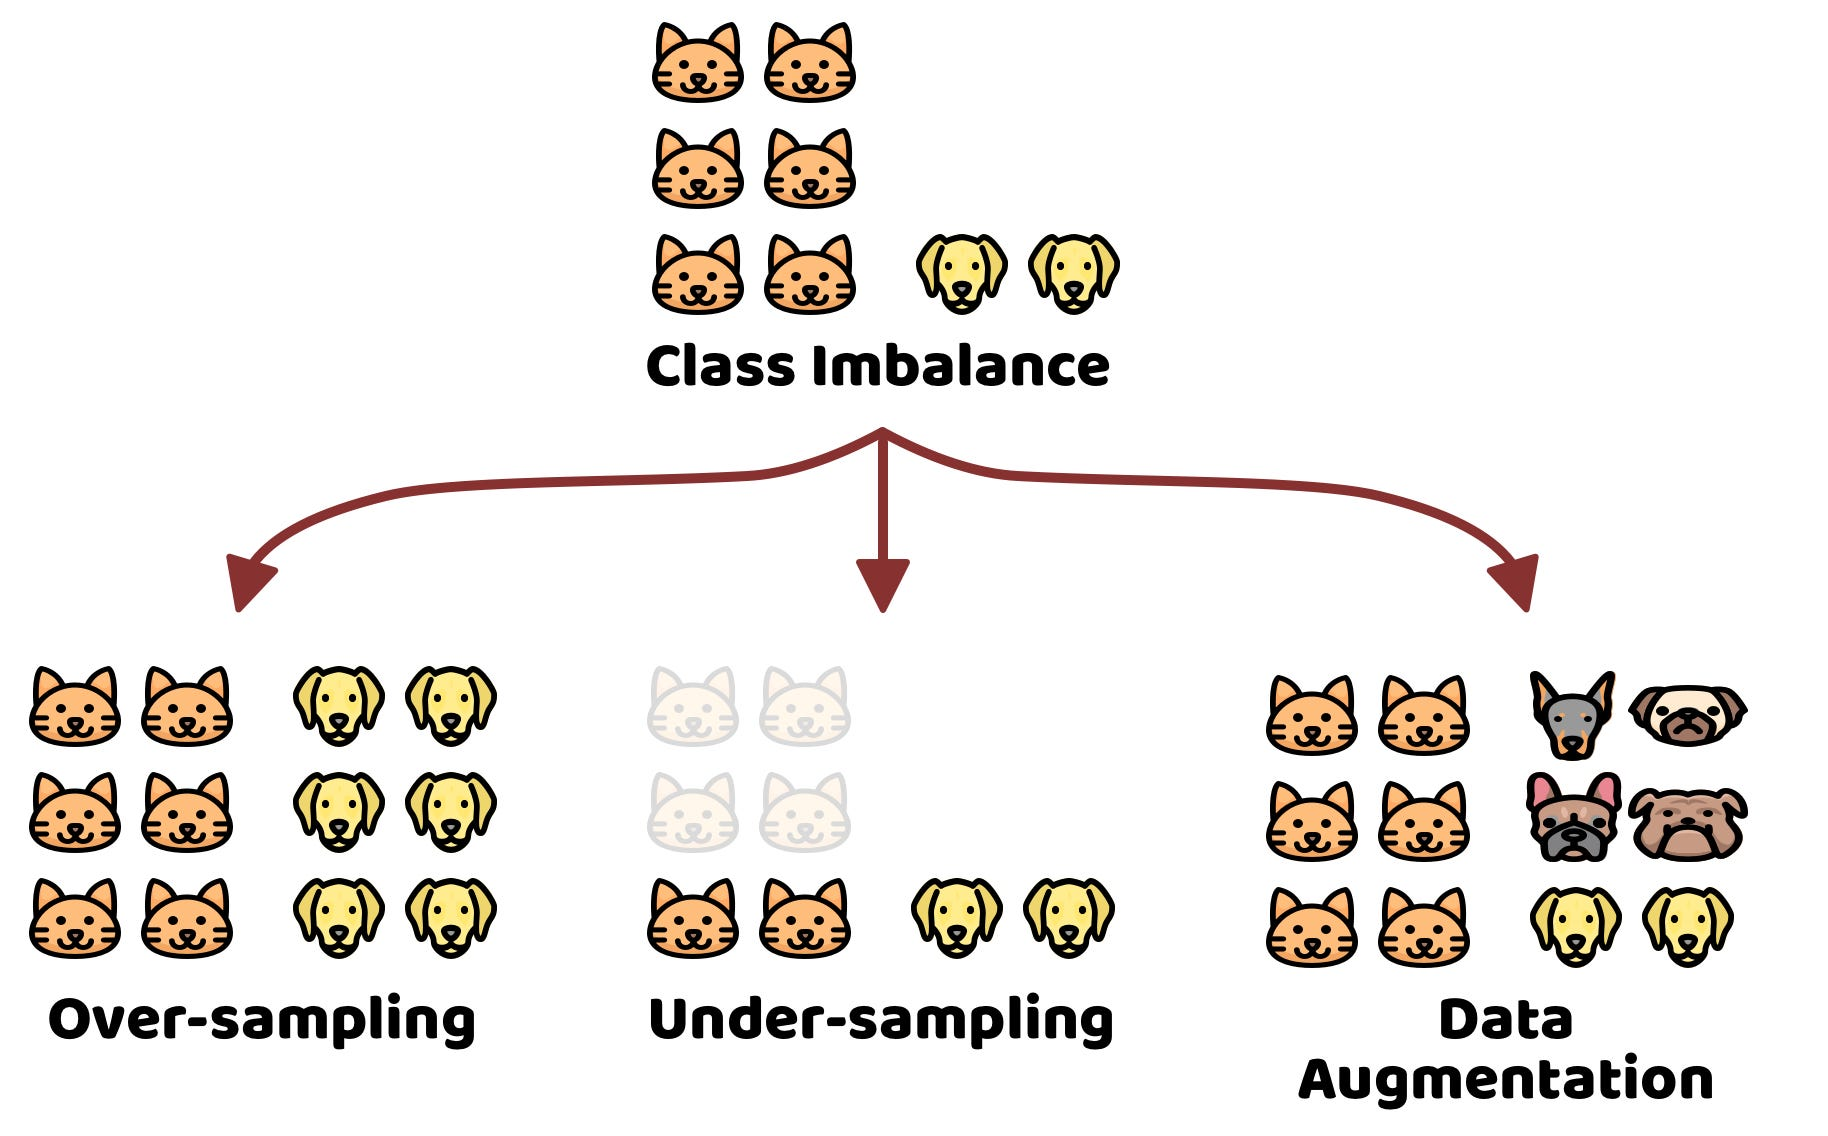



---



#### 🤏 **Undersamping techniques**

##### ⭕ *Random Undersampling*

**IDEA**: Randomly removes samples from the majority class (normal transactions) until the class ratio is more balanced

When undersampling to the size of the `fraud` class (1 : 1)

In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

rus_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# k-fold cross validation
for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  # model to try
  model = LogisticRegression(
      max_iter=1000,
      random_state=42,
  )

  # calculate size of resampling
  legitimate_size = y_train_fold.value_counts().max()
  fraud_size = y_train_fold.value_counts().min()

  # the sampler
  rus = RandomUnderSampler(
      random_state=42,
      sampling_strategy="majority"
      # sampling_strategy={
      #     0: int(0.1 * legitimate_size),
      #     1: fraud_size
      # }
  )

  # create the pipeline, only apply the resampler on
  # the train_fold, no touch for the val_fold
  pipeline = Pipeline(
      [
          ("undersampler", rus),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  rus_results.loc[len(rus_results)] = [idx] + metrics

  print(f"- Fold {idx}/{kf.get_n_splits()} done.")

- Fold 1/5 done.
- Fold 2/5 done.
- Fold 3/5 done.
- Fold 4/5 done.
- Fold 5/5 done.


In [ ]:
rus_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.962014,0.041088,0.948718,0.078765,0.175106,0.037964,0.955377
1,2.0,0.953499,0.032110,0.886076,0.061974,0.140224,0.046384,0.919846
2,3.0,0.967763,0.045752,0.886076,0.087011,0.189599,0.032095,0.926990
3,4.0,0.951656,0.032982,0.949367,0.063748,0.144788,0.048340,0.950513
4,5.0,0.950558,0.031466,0.924051,0.060859,0.138467,0.049395,0.937328


When keep up to 0.3 of the majority size (not 1 : 1 anymore)

In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

rus_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# k-fold cross validation
for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  # model to try
  model = LogisticRegression(
      max_iter=1000,
      random_state=42,
  )

  # calculate size of resampling
  legitimate_size = y_train_fold.value_counts().max()
  fraud_size = y_train_fold.value_counts().min()

  # the sampler
  rus = RandomUnderSampler(
      random_state=42,
      sampling_strategy={
          0: int(0.3 * legitimate_size),
          1: fraud_size
      }
  )

  # create the pipeline, only apply the resampler on
  # the train_fold, no touch for the val_fold
  pipeline = Pipeline(
      [
          ("undersampler", rus),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  rus_results.loc[len(rus_results)] = [idx] + metrics

  print(f"- Fold {idx}/{kf.get_n_splits()} done.")

- Fold 1/5 done.
- Fold 2/5 done.
- Fold 3/5 done.
- Fold 4/5 done.
- Fold 5/5 done.


In [ ]:
rus_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.999364,0.835616,0.782051,0.807947,0.792208,0.000264,0.890894
1,2.0,0.999386,0.859155,0.772152,0.813333,0.788114,0.000220,0.885966
2,3.0,0.999188,0.776316,0.746835,0.761290,0.752551,0.000374,0.873231
3,4.0,0.999232,0.775000,0.784810,0.779874,0.782828,0.000396,0.892207
4,5.0,0.999232,0.823529,0.708861,0.761905,0.729167,0.000264,0.854298


In [ ]:
rus_results.mean().head(100)

,0
idx,3.000000
accuracy,0.999280
precision,0.813923
recall,0.758942
f1,0.784870
f2,0.768973
fpr,0.000303
roc_auc,0.879319


**NOTE**: When applying the `RandomUnderSampler`, train and evaluate using `k-fold cross validation`, we can notice the `precision` significantly decrease (from ~0.8 to ~0.03), but `recall` considerably increase on overal (from ~0.6 to ~0.9), meaning that the classifier now can captures most of fraud transactions, however because `precision` is so low, when the classifier says the current transaction is a fraud one, most of the time, it is a `false positive` case (a legitimate transaction). The reason for this behaviour can be explained as follows:
- `recall` increases decently because the model now sees frauds as equally important as normals during training, so it becomes very sensitive to detecting fraud
- Because we apply the `RandomUnderSampler`, we have lost most of the information of the legitimate transactions (the model loses context about what `normal` looks like.), thus the classifier doesn't have enough data to generalize the pattern well, thus `precision` decreases considerably as expected

In the second case, we chose to reduce the imbalance enough so that the model hace chance to pay attention to `fraud` patterns (only reducing the `legitimate` class to a certern ratio to the `fraud` class), this prevent the model to bias the majority, while allowing the model to learn pattern from the rare `fraud` cases (we keep 0.1 of the original size which gives us a decent F2 score)


---

The problem is `Potential Information loss` when undersampling class 0 to the class ratio 1:1



---



##### ❌ *NearMiss Undersampling*

**IDEA**: Keep those majority samples that are `most confusing` or `closest` to fraud cases as those are most informative for the classifier to learn a good decision boundary

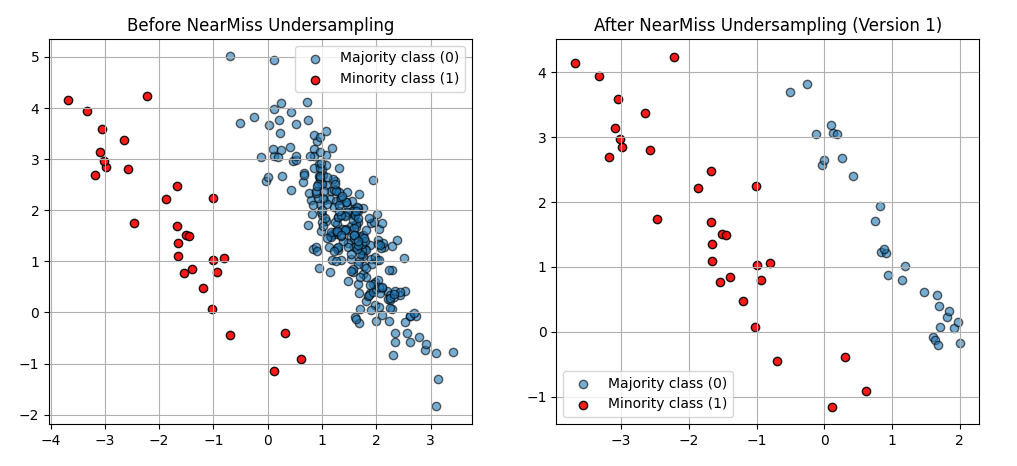



---



In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

nm_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  model = LogisticRegression(
      random_state=42,
      max_iter=1000
  )

  # near miss undersampler
  nm = NearMiss(
      version=1,
      n_neighbors=3
  )

  pipeline = Pipeline(
      [
          ("nearmiss", nm),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  nm_results.loc[len(nm_results)] = [idx] + metrics

  print(f"- Fold {idx}/{kf.get_n_splits()} done.")

- Fold 1/5 done.
- Fold 2/5 done.
- Fold 3/5 done.
- Fold 4/5 done.
- Fold 5/5 done.


In [ ]:
nm_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.205030,0.002149,1.000000,0.004288,0.010651,0.796333,0.601833
1,2.0,0.257807,0.002242,0.962025,0.004474,0.011108,0.743416,0.609305
2,3.0,0.245452,0.002148,0.936709,0.004286,0.010642,0.755749,0.590480
3,4.0,0.198775,0.002132,0.987342,0.004255,0.010568,0.802594,0.592374
4,5.0,0.184160,0.002094,0.987342,0.004179,0.010381,0.817235,0.585054


**NOTE**: The model basically predicts `fraud` for almost everything. Which results in low `precision` and very high `recall`. Then why is that?
- There might be no clear boundary, the minority points are embedded within majority regions
- It might be the case that the sample points for `fraud` and `legitimate` transactions are strongly overlapped (as demonstrated with a similar example in 2D), then based on NearMiss algorithm, only the most confused `Normal` transactions are kept, and this inadventently drops most of the important `Normal` transactions, the model only has the chance to learn `Normal` transactions which are similar to `fraud` transaction (confusing region only - only “fraud-like” `normal` transactions). Which results in very low `precision`, because it doesn't have enough information to correctly alert the `fraud` ones, which leads to the model predicts `fraud` for almost every cases, thus `recall` is really high, but `FPR` also becomes consirably high

##### ❌ *Tomek links Undersampling*

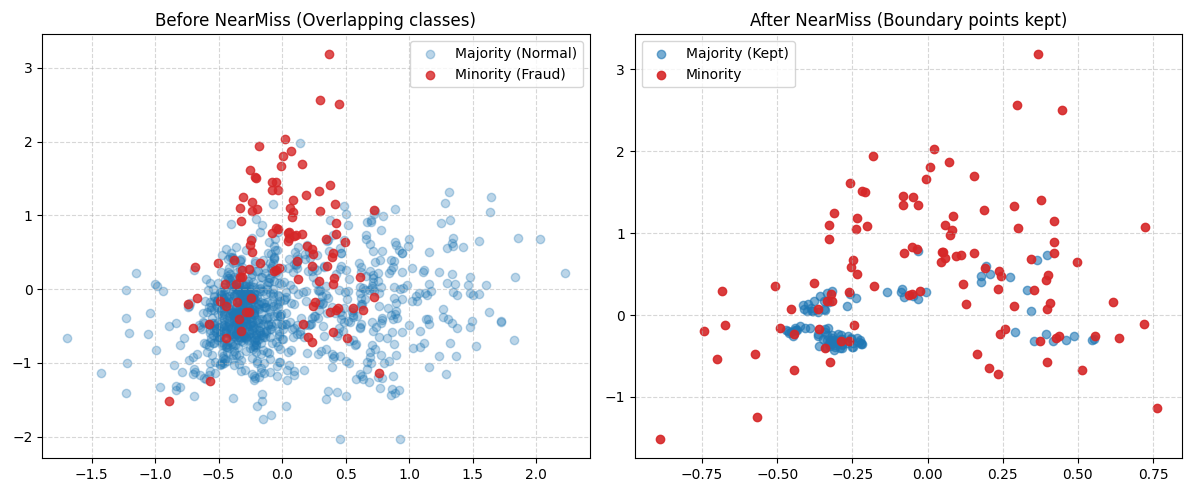

**IDEA**: A Tomek Link represents a borderline pair of samples that are very close but belong to opposite classes. These pairs mark ambiguous regions between classes. Tomek Links identify and remove those confusing majority samples near the minority samples to clean the boundary.

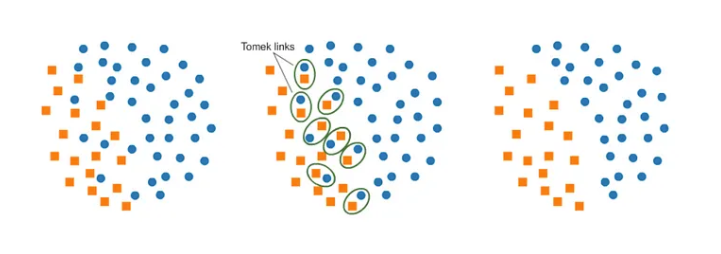

In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

tl_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  model = LogisticRegression(
      random_state=42,
      max_iter=1000
  )

  # Tomek Links cleaner
  tl = TomekLinks(
      sampling_strategy="majority",
      n_jobs=-1
  )

  # Pipeline

  pipeline = Pipeline(
      [
          ("tomek_links", tl),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  tl_results.loc[len(tl_results)] = [idx] + metrics

  print(f"- Fold {idx}/{kf.get_n_splits()} done.")

- Fold 1/5 done.
- Fold 2/5 done.
- Fold 3/5 done.
- Fold 4/5 done.
- Fold 5/5 done.


In [ ]:
tl_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.999276,0.909091,0.641026,0.751880,0.681199,0.000110,0.820458
1,2.0,0.999254,0.924528,0.620253,0.742424,0.663957,0.000088,0.810083
2,3.0,0.999254,0.846154,0.696203,0.763889,0.721785,0.000220,0.847991
3,4.0,0.999188,0.850000,0.645570,0.733813,0.678191,0.000198,0.822686
4,5.0,0.999232,0.892857,0.632911,0.740741,0.672043,0.000132,0.816390


In [ ]:
tl_results.mean().head(100)

,0
idx,3.000000
accuracy,0.999241
precision,0.884526
recall,0.647192
f1,0.746549
f2,0.683435
fpr,0.000149
roc_auc,0.823521


**NOTE**: Overall, these metrics don't change much compared with the `baseline` version, this might happen because although the confused legitimate transactions are reduced, if the sample points are not at least separated in those high dimensions (meaning they heavily overlap to each other), then removing the confused sample points, doesn't make the decision boundary to become clear for the classifier. The classifier still misses a lot of `fraud` transactions, and inadvertently classifies them as `legitimate`. Besides, Tomek Links don't heavily change the class distribution, then the model still sees a lot of `legitimate` cases over `fraud` cases, thus unable to further capture more `fraud` cases (`recall` doesn't change much)

##### ⭕ *Cluster Centroids Undersampling*

**IDEA**: Instead of removing samples randomly, `Cluster Centroids` tries to summarize the majority class samples using K-Means clustering, keeps representative samples of the majority class

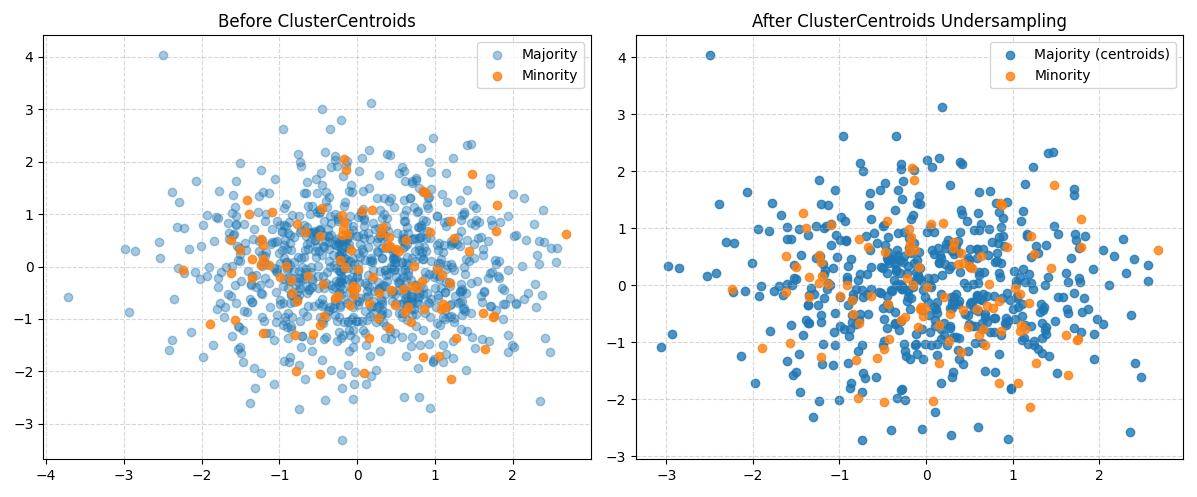

In [ ]:
y_train.value_counts()

,count
Class,
0,227451
1,394


In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cc_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# k-fold cross validation
for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  print(f"- Fold {idx}/{kf.get_n_splits()} started!")
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
  print("* Data splitting done!")

  # model to try
  model = LogisticRegression(
      max_iter=1500,
      random_state=42,
  )

  # calculate size of resampling
  legitimate_size = y_train_fold.value_counts().max()
  fraud_size = y_train_fold.value_counts().min()

  # the sampler
  cc = ClusterCentroids(
      estimator=MiniBatchKMeans(
          batch_size=1024,
          max_iter=100,
          random_state=42
          ),
      random_state=42,
      # lost too much information
      # sampling_strategy="majority"

      # keeping 0.5 representative legitimate cases to prevent
      # information loss
      sampling_strategy={
          0: int(0.1 * legitimate_size),
          1: fraud_size
      },
  )

  # create the pipeline, only apply the resampler on
  # the train_fold, no touch for the val_fold
  pipeline = Pipeline(
      [
          ("undersampler", cc),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  print("* Training pipeline done!")
  y_pred = pipeline.predict(X_val_fold)

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  cc_results.loc[len(cc_results)] = [idx] + metrics
  print("* Collect metrics done!")

  print(f"- Fold {idx}/{kf.get_n_splits()} done!")

- Fold 1/5 started!
* Data splitting done!
* Training pipeline done!
* Collect metrics done!
- Fold 1/5 done!
- Fold 2/5 started!
* Data splitting done!
* Training pipeline done!
* Collect metrics done!
- Fold 2/5 done!
- Fold 3/5 started!
* Data splitting done!
* Training pipeline done!
* Collect metrics done!
- Fold 3/5 done!
- Fold 4/5 started!
* Data splitting done!
* Training pipeline done!
* Collect metrics done!
- Fold 4/5 done!
- Fold 5/5 started!
* Data splitting done!
* Training pipeline done!
* Collect metrics done!
- Fold 5/5 done!


In [ ]:
cc_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.999386,0.828947,0.807692,0.818182,0.811856,0.000286,0.903703
1,2.0,0.999386,0.849315,0.784810,0.815789,0.796915,0.000242,0.892284
2,3.0,0.999078,0.722892,0.759494,0.740741,0.751880,0.000506,0.879494
3,4.0,0.999298,0.770115,0.848101,0.807229,0.831266,0.000440,0.923831
4,5.0,0.999188,0.762500,0.772152,0.767296,0.770202,0.000418,0.885867


In [ ]:
cc_results.mean().head(100)

,0
idx,3.000000
accuracy,0.999267
precision,0.786754
recall,0.794450
f1,0.789847
f2,0.792424
fpr,0.000378
roc_auc,0.897036


**NOTE**: To prevent information loss (happened in other undersampling techniques tried previously), the `sampling_strategy` has changed to keep enough a number of representatives `legitimate` transactions, we can obviously see that `recall` increases while `precision` can keep at a decent level, the model becomes less biased towards `majority` class, sentitive to `minority` cases. Controlled undersampling (ClusterCentroids + partial strategy), maintains both decent `precision` and improved `recall`. This undersampling method can be a `candidate` for final evaluation



---



##### 💎 **SUMMARY**: Generally, when applying those `Undersampling` techniques, we oftens face problem of `information loss` (except for `Cluster Centroids Undersampling`, the model can reduce the bias by keeping enough majority class), meaning that the model still don't really have enough samples of `legitimate` transactions to learn the pattern. Those techniques remove most of the `legitimate` transactions, which are actually rich sources of information about what normal looks like. The point of `Undersampling` is to reduce the bias towards the majority class, but those techniques tried above painfully reduce the majority class, thus reversely making the model have bias toward the minority (`fraud`), as we can check the `recall`, they are always high values, while `precision` scores are tragically low, thus `Undersampling` techniques generally can benefit the model but only when we can choose a `smart ratio` to undersample



---



#### 👐 **Oversampling techniques**

##### ⭕ *Random Oversampling*

In [ ]:
y_train.value_counts()

,count
Class,
0,227451
1,394


**IDEA**: Random oversampling randomly duplicate samples of the minority class until the class is balanced

When oversampling to ratio 1:1

In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

ros_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  model = LogisticRegression(
      random_state=42,
      max_iter=1000
  )

  # calculate size of resampling
  legitimate_size = y_train_fold.value_counts().max()
  fraud_size = y_train_fold.value_counts().min()

  ros = RandomOverSampler(
      random_state=42,
      sampling_strategy="minority"
  )

  # Pipeline

  pipeline = Pipeline(
      [
          ("resampler", ros),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  ros_results.loc[len(ros_results)] = [idx] + metrics

  print(f"- Fold {idx}/{kf.get_n_splits()} done.")

- Fold 1/5 done.
- Fold 2/5 done.
- Fold 3/5 done.
- Fold 4/5 done.
- Fold 5/5 done.


In [ ]:
ros_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.974325,0.058966,0.935897,0.110942,0.235484,0.025609,0.955144
1,2.0,0.977507,0.066055,0.911392,0.123182,0.256046,0.022379,0.944507
2,3.0,0.977682,0.064126,0.873418,0.119481,0.247845,0.022137,0.925640
3,4.0,0.973249,0.057453,0.936709,0.108266,0.230673,0.026687,0.955011
4,5.0,0.975422,0.060017,0.898734,0.112520,0.236825,0.024445,0.937145


In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

ros_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  model = LogisticRegression(
      random_state=42,
      max_iter=1000
  )

  # calculate size of resampling
  legitimate_size = y_train_fold.value_counts().max()
  fraud_size = y_train_fold.value_counts().min()

  ros = RandomOverSampler(
      random_state=42,
      sampling_strategy={
          0: legitimate_size,
          1: 20 * fraud_size
      }
  )

  # Pipeline

  pipeline = Pipeline(
      [
          ("resampler", ros),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  ros_results.loc[len(ros_results)] = [idx] + metrics

  print(f"- Fold {idx}/{kf.get_n_splits()} done.")

- Fold 1/5 done.
- Fold 2/5 done.
- Fold 3/5 done.
- Fold 4/5 done.
- Fold 5/5 done.


In [ ]:
ros_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.999144,0.709677,0.846154,0.771930,0.814815,0.000594,0.922780
1,2.0,0.999100,0.715909,0.797468,0.754491,0.779703,0.000550,0.898459
2,3.0,0.998771,0.611650,0.797468,0.692308,0.751790,0.000879,0.898295
3,4.0,0.999012,0.654545,0.911392,0.761905,0.845070,0.000835,0.955279
4,5.0,0.999034,0.692308,0.797468,0.741176,0.773956,0.000616,0.898426


In [ ]:
ros_results.mean().head(100)

,0
idx,3.000000
accuracy,0.999012
precision,0.676818
recall,0.829990
f1,0.744362
f2,0.793067
fpr,0.000695
roc_auc,0.914648


**NOTE**: Obviously, we can see the same pattern that happens with `Undersampling technique`, the oversampler creates many dupplicated samples from a small set `fraud` ones, on unseen data, it becomes over-confident that a transaction is a `fraud` one, which makes the `precision` is so low in the first case, but very high `recall`. But when oversampling paritially (ratio not 1:1) like in the second case, the dataset after oversampling still retains realistic imbalance, more duplicated `fraud` cases make the model become sensitive to `fraud` transaction, thus overall, comparing to the baseline, `recall` is improved significantly, `precision` is still at a decent level

##### ⭕ *SMOTE Oversampling*

**IDEA**: SMOTE creates new, `synthetic` samples, new points that lie between existing minority class samples, SMOTE `interpolates` new synthetic points that enrich the minority region of the feature space

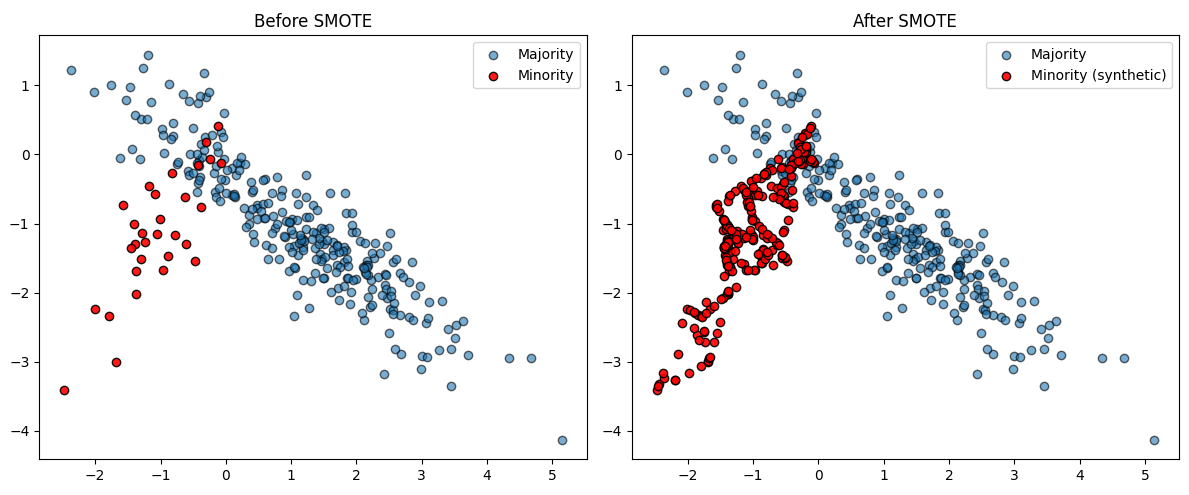

In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

smote_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  print(f"--- Fold {idx}/{kf.get_n_splits()} started!")

  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  model = LogisticRegression(
      random_state=42,
      max_iter=1500
  )

  # calculate size of resampling
  # legitimate_size = y_train_fold.value_counts().max()
  # fraud_size = y_train_fold.value_counts().min()

  smote = SMOTE(
      sampling_strategy="minority",
      random_state=42
  )

  # Pipeline

  pipeline = Pipeline(
      [
          ("resampler", smote),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  print("* Done training")

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  smote_results.loc[len(smote_results)] = [idx] + metrics
  print("* Done collecting metrics")

  print(f"* Fold {idx}/{kf.get_n_splits()} done!")

--- Fold 1/5 started!
* Done training
* Done collecting metrics
* Fold 1/5 done!
--- Fold 2/5 started!
* Done training
* Done collecting metrics
* Fold 2/5 done!
--- Fold 3/5 started!
* Done training
* Done collecting metrics
* Fold 3/5 done!
--- Fold 4/5 started!
* Done training
* Done collecting metrics
* Fold 4/5 done!
--- Fold 5/5 started!
* Done training
* Done collecting metrics
* Fold 5/5 done!


In [ ]:
smote_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.982729,0.083431,0.910256,0.152853,0.305245,0.017146,0.946555
1,2.0,0.983037,0.082933,0.873418,0.151482,0.300523,0.016773,0.928322
2,3.0,0.984858,0.092123,0.873418,0.166667,0.323944,0.014948,0.929235
3,4.0,0.980316,0.075726,0.924051,0.139981,0.285156,0.019587,0.952232
4,5.0,0.980052,0.072165,0.886076,0.133460,0.272162,0.019785,0.933146


In [ ]:
smote_results.mean().head(100)

,0
idx,3.000000
accuracy,0.982198
precision,0.081276
recall,0.893444
f1,0.148888
f2,0.297406
fpr,0.017648
roc_auc,0.937898


In [ ]:
y_train.value_counts()

,count
Class,
0,227451
1,394


In [ ]:
# define the k-fold
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

smote_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  print(f"--- Fold {idx}/{kf.get_n_splits()} started!")

  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  model = LogisticRegression(
      random_state=42,
      max_iter=1500
  )

  # calculate size of resampling
  legitimate_size = y_train_fold.value_counts().max()
  fraud_size = y_train_fold.value_counts().min()

  smote = SMOTE(
      sampling_strategy={
          0: legitimate_size,
          1: 15 * fraud_size
      },
      random_state=42
  )

  # Pipeline

  pipeline = Pipeline(
      [
          ("resampler", smote),
          ("model", model)
      ]
  )

  pipeline.fit(X=X_train_fold, y=y_train_fold)
  y_pred = pipeline.predict(X_val_fold)

  print("* Done training")

  # metrics
  metrics = collect_metrics(y_val_fold, y_pred)
  smote_results.loc[len(smote_results)] = [idx] + metrics
  print("* Done collecting metrics")

  print(f"* Fold {idx}/{kf.get_n_splits()} done!")

--- Fold 1/5 started!
* Done training
* Done collecting metrics
* Fold 1/5 done!
--- Fold 2/5 started!
* Done training
* Done collecting metrics
* Fold 2/5 done!
--- Fold 3/5 started!
* Done training
* Done collecting metrics
* Fold 3/5 done!
--- Fold 4/5 started!
* Done training
* Done collecting metrics
* Fold 4/5 done!
--- Fold 5/5 started!
* Done training
* Done collecting metrics
* Fold 5/5 done!


In [ ]:
smote_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.999276,0.758621,0.846154,0.800000,0.827068,0.000462,0.922846
1,2.0,0.999210,0.765432,0.784810,0.775000,0.780856,0.000418,0.892196
2,3.0,0.998947,0.663158,0.797468,0.724138,0.766423,0.000703,0.898382
3,4.0,0.999144,0.700000,0.886076,0.782123,0.841346,0.000659,0.942708
4,5.0,0.999122,0.724138,0.797468,0.759036,0.781638,0.000528,0.898470


In [ ]:
smote_results.mean().head(100)

,0
idx,3.000000
accuracy,0.999140
precision,0.722270
recall,0.822395
f1,0.768059
f2,0.799466
fpr,0.000554
roc_auc,0.910921


**NOTE**: Obviously, the same problem now happens in the case of `SMOTE`, when we oversample the `fraud` transactions to the size of the `legitlimate` transactions, the metrics recorded, no surprise, and was expected to be very low on `precision` and very decent `recall`, the same reason applied, as we makes many synthesic `fraud` cases, the model have many samples to learn the pattern, thus making the model to be more sensitive to `fraud` transactions, howevery, because it now saw many `fraud` cases, might be the SMOTE actually synthesize the `fraud` transactions which inadvertently look like `legitimate` transactions, thus this confuses the model between `fraud` and `legitimate` transactions, and when the model thinks the transaction is a `fraud`, it is actually `legitimate`, thus making the `precision` to be very low? But when smartly oversampling (tune the ratio a bit), the model doesn't bias the majority, but still have synthetic samples for the `fraud` transactions, thus it becomes sensitive to the `fraud`, but doesn't lose it `precision` a lot like the first case



---



##### 💎 **SUMMARY**: Generally, oversampling techniques like `Random Oversampling` and `SMOTE Oversampling` add or create synthetic samples of the minority class in doing so, we hope it will decrease the bias forward the majority class, and as we have observed, the number of dupplicated or created samples must be carefully tuned as over-oversampling can make make the model sensitive to the minority class, leading to certain problems aas above like precision very low or FPR becomes extremely high (decision boundary moves to the left, classifying many `normal` samples as `fraud`)



---



#### 🙏 What is the `best ratio` for oversampling to use?

##### 🧪 Try ratio from 0.002-1 (Globally)

In [ ]:
ratio_results = pd.DataFrame(
    columns=[
        "ratio",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# rate = [minority] / [majority]
# run from actual m/M to m -> M, which is 1
# m/M is preserved to be
# no resampling
rate_0 = 0.002     # 0.00173 (start from 0.002)
rate_1 = 1 / 1
num_part = 5

rates = np.linspace(rate_0, rate_1, num_part + 1)

for rate in rates:
  print(f"Rate {rate:.5f} started!")

  metrics = []

  # define the k-fold
  kf = StratifiedKFold(
      n_splits=5,
      shuffle=True,
      random_state=42
  )

  # validate using k-fold validation
  for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LogisticRegression(
        random_state=42,
        max_iter=1500
    )

    smote = SMOTE(
        sampling_strategy=rate,
        random_state=42,
    )

    # Pipeline

    pipeline = Pipeline(
        [
            ("resampler", smote),
            ("model", model)
        ]
    )

    pipeline.fit(X=X_train_fold, y=y_train_fold)
    y_pred = pipeline.predict(X_val_fold)

    # metrics
    metric = collect_metrics(y_val_fold, y_pred)
    metrics.append(metric)
    print(f"-- Done fold {idx}/{kf.get_n_splits()}")

  print("5-fold validation done!")

  # calculate metrics' mean
  metrics = np.array(metrics)
  mean_metrics = np.mean(metrics, axis=0)

  print("Collect metrics done!")

  ratio_results.loc[len(ratio_results)] = [rate] + mean_metrics.tolist()

  print("Store metrics done!")
  print(mean_metrics)

  print(f"Rate {rate} done!")
  # list of metric
  # [[0,9, ...],
  #  [0.9, ...],
  #  [0.9, ...]]

Rate 0.00200 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99249490e-01 8.79886782e-01 6.57383966e-01 7.51809180e-01
 6.92040368e-01 1.58275964e-04 8.28612845e-01]
Rate 0.002 done!
Rate 0.20160 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[0.9956725  0.26726756 0.86049984 0.40764461 0.59552796 0.00409319
 0.92820332]
Rate 0.2016 done!
Rate 0.40120 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[0.99263096 0.17473906 0.87322298 0.29104868 0.4848064  0.00716198
 0.9330305 ]
Rate 0.4012 done!
Rate 0.60080 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store m

In [ ]:
ratio_results.head(100)

,ratio,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,0.0020,0.999249,0.879887,0.657384,0.751809,0.692040,0.000158,0.828613
1,0.2016,0.995672,0.267268,0.860500,0.407645,0.595528,0.004093,0.928203
2,0.4012,0.992631,0.174739,0.873223,0.291049,0.484806,0.007162,0.933030
3,0.6008,0.989142,0.125744,0.880785,0.219892,0.399506,0.010670,0.935058
4,0.8004,0.985600,0.098266,0.888380,0.176822,0.340002,0.014232,0.937074
5,1.0000,0.982198,0.081276,0.893444,0.148888,0.297406,0.017648,0.937898


##### 🧪 Try ratio from 0.002-0.2016

In [ ]:
ratio_results = pd.DataFrame(
    columns=[
        "ratio",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# rate = [minority] / [majority]
# run from actual m/M to m -> M, which is 1
# m/M is preserved to be
# no resampling
rate_0 = 0.002     # 0.00173 (start from 0.002)
rate_1 = 0.2016
num_part = 5

rates = np.linspace(rate_0, rate_1, num_part + 1)

for rate in rates:
  print(f"Rate {rate:.5f} started!")

  metrics = []

  # define the k-fold
  kf = StratifiedKFold(
      n_splits=5,
      shuffle=True,
      random_state=42
  )

  # validate using k-fold validation
  for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LogisticRegression(
        random_state=42,
        max_iter=1500
    )

    smote = SMOTE(
        sampling_strategy=rate,
        random_state=42,
    )

    # Pipeline

    pipeline = Pipeline(
        [
            ("resampler", smote),
            ("model", model)
        ]
    )

    pipeline.fit(X=X_train_fold, y=y_train_fold)
    y_pred = pipeline.predict(X_val_fold)

    # metrics
    metric = collect_metrics(y_val_fold, y_pred)
    metrics.append(metric)
    print(f"-- Done fold {idx}/{kf.get_n_splits()}")

  print("5-fold validation done!")

  # calculate metrics' mean
  metrics = np.array(metrics)
  mean_metrics = np.mean(metrics, axis=0)

  print("Collect metrics done!")

  ratio_results.loc[len(ratio_results)] = [rate] + mean_metrics.tolist()

  print("Store metrics done!")
  print(mean_metrics)

  print(f"Rate {rate} done!")
  # list of metric
  # [[0,9, ...],
  #  [0.9, ...],
  #  [0.9, ...]]

Rate 0.00200 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99249490e-01 8.79886782e-01 6.57383966e-01 7.51809180e-01
 6.92040368e-01 1.58275964e-04 8.28612845e-01]
Rate 0.002 done!
Rate 0.04192 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.98964208e-01 6.59934929e-01 8.32521908e-01 7.35670250e-01
 7.90679268e-01 7.47414115e-04 9.15887247e-01]
Rate 0.04192 done!
Rate 0.08184 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[0.99822686 0.49363001 0.84268095 0.62186109 0.73750869 0.00150362
 0.92058866]
Rate 0.08184 done!
Rate 0.12176 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!

In [ ]:
ratio_results.head(100)

,ratio,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,0.00200,0.999249,0.879887,0.657384,0.751809,0.692040,0.000158,0.828613
1,0.04192,0.998964,0.659935,0.832522,0.735670,0.790679,0.000747,0.915887
2,0.08184,0.998227,0.493630,0.842681,0.621861,0.737509,0.001504,0.920589
3,0.12176,0.997209,0.368186,0.855437,0.514426,0.675870,0.002546,0.926445
4,0.16168,0.996357,0.304150,0.857968,0.448960,0.628694,0.003403,0.927283
5,0.20160,0.995672,0.267268,0.860500,0.407645,0.595528,0.004093,0.928203


##### 🧪 Try ratio from 0.002-0.04192

In [ ]:
ratio_results = pd.DataFrame(
    columns=[
        "ratio",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# rate = [minority] / [majority]
# run from actual m/M to m -> M, which is 1
# m/M is preserved to be
# no resampling
rate_0 = 0.002     # 0.00173 (start from 0.002)
rate_1 = 0.04192
num_part = 5

rates = np.linspace(rate_0, rate_1, num_part + 1)

for rate in rates:
  print(f"Rate {rate:.5f} started!")

  metrics = []

  # define the k-fold
  kf = StratifiedKFold(
      n_splits=5,
      shuffle=True,
      random_state=42
  )

  # validate using k-fold validation
  for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LogisticRegression(
        random_state=42,
        max_iter=1500
    )

    smote = SMOTE(
        sampling_strategy=rate,
        random_state=42,
    )

    # Pipeline

    pipeline = Pipeline(
        [
            ("resampler", smote),
            ("model", model)
        ]
    )

    pipeline.fit(X=X_train_fold, y=y_train_fold)
    y_pred = pipeline.predict(X_val_fold)

    # metrics
    metric = collect_metrics(y_val_fold, y_pred)
    metrics.append(metric)
    print(f"-- Done fold {idx}/{kf.get_n_splits()}")

  print("5-fold validation done!")

  # calculate metrics' mean
  metrics = np.array(metrics)
  mean_metrics = np.mean(metrics, axis=0)

  print("Collect metrics done!")

  ratio_results.loc[len(ratio_results)] = [rate] + mean_metrics.tolist()

  print("Store metrics done!")
  print(mean_metrics)

  print(f"Rate {rate} done!")
  # list of metric
  # [[0,9, ...],
  #  [0.9, ...],
  #  [0.9, ...]]

Rate 0.00200 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99249490e-01 8.79886782e-01 6.57383966e-01 7.51809180e-01
 6.92040368e-01 1.58275964e-04 8.28612845e-01]
Rate 0.002 done!
Rate 0.00998 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99319713e-01 8.08608487e-01 7.96981500e-01 8.02154954e-01
 7.98896086e-01 3.29741737e-04 8.98325879e-01]
Rate 0.009984 done!
Rate 0.01797 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99231934e-01 7.59193142e-01 8.17299578e-01 7.86227871e-01
 8.04325389e-01 4.52844847e-04 9.08423367e-01]
Rate 0.017967999999999998 done!
Rate 0.02595 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/

In [ ]:
ratio_results.head(100)

,ratio,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,0.002000,0.999249,0.879887,0.657384,0.751809,0.692040,0.000158,0.828613
1,0.009984,0.999320,0.808608,0.796981,0.802155,0.798896,0.000330,0.898326
2,0.017968,0.999232,0.759193,0.817300,0.786228,0.804325,0.000453,0.908423
3,0.025952,0.999162,0.729653,0.824927,0.773270,0.803136,0.000536,0.912195
4,0.033936,0.999056,0.690784,0.827459,0.752278,0.795434,0.000646,0.913406
5,0.041920,0.998964,0.659935,0.832522,0.735670,0.790679,0.000747,0.915887


##### 🧪 Try ratio from 0.002-0.025952

In [ ]:
ratio_results = pd.DataFrame(
    columns=[
        "ratio",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# rate = [minority] / [majority]
# run from actual m/M to m -> M, which is 1
# m/M is preserved to be
# no resampling
rate_0 = 0.002     # 0.00173 (start from 0.002)
rate_1 = 0.025952
num_part = 5

rates = np.linspace(rate_0, rate_1, num_part + 1)

for rate in rates:
  print(f"Rate {rate:.5f} started!")

  metrics = []

  # define the k-fold
  kf = StratifiedKFold(
      n_splits=5,
      shuffle=True,
      random_state=42
  )

  # validate using k-fold validation
  for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LogisticRegression(
        random_state=42,
        max_iter=1500
    )

    smote = SMOTE(
        sampling_strategy=rate,
        random_state=42,
    )

    # Pipeline

    pipeline = Pipeline(
        [
            ("resampler", smote),
            ("model", model)
        ]
    )

    pipeline.fit(X=X_train_fold, y=y_train_fold)
    y_pred = pipeline.predict(X_val_fold)

    # metrics
    metric = collect_metrics(y_val_fold, y_pred)
    metrics.append(metric)
    print(f"-- Done fold {idx}/{kf.get_n_splits()}")

  print("5-fold validation done!")

  # calculate metrics' mean
  metrics = np.array(metrics)
  mean_metrics = np.mean(metrics, axis=0)

  print("Collect metrics done!")

  ratio_results.loc[len(ratio_results)] = [rate] + mean_metrics.tolist()

  print("Store metrics done!")
  print(mean_metrics)

  print(f"Rate {rate} done!")
  # list of metric
  # [[0,9, ...],
  #  [0.9, ...],
  #  [0.9, ...]]

Rate 0.00200 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99249490e-01 8.79886782e-01 6.57383966e-01 7.51809180e-01
 6.92040368e-01 1.58275964e-04 8.28612845e-01]
Rate 0.002 done!
Rate 0.00679 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99328491e-01 8.18631118e-01 7.89386563e-01 8.02877362e-01
 7.94520219e-01 3.07758981e-04 8.94539402e-01]
Rate 0.0067904 done!
Rate 0.01158 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99302157e-01 7.94971838e-01 8.07140539e-01 7.99995923e-01
 8.04000629e-01 3.64914110e-04 9.03387812e-01]
Rate 0.0115808 done!
Rate 0.01637 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done 

In [ ]:
ratio_results.head(100)

,ratio,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,0.002000,0.999249,0.879887,0.657384,0.751809,0.692040,0.000158,0.828613
1,0.006790,0.999328,0.818631,0.789387,0.802877,0.794520,0.000308,0.894539
2,0.011581,0.999302,0.794972,0.807141,0.799996,0.804001,0.000365,0.903388
3,0.016371,0.999245,0.765372,0.817300,0.789325,0.805561,0.000440,0.908430
4,0.021162,0.999175,0.736538,0.819831,0.774730,0.800829,0.000514,0.909658
5,0.025952,0.999162,0.729653,0.824927,0.773270,0.803136,0.000536,0.912195


##### 🧪 Try ratio from 0.002-0.03

In [ ]:
ratio_results = pd.DataFrame(
    columns=[
        "ratio",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# rate = [minority] / [majority]
# run from actual m/M to m -> M, which is 1
# m/M is preserved to be
# no resampling
rate_0 = 0.002     # 0.00173 (start from 0.002)
rate_1 = 0.03
num_part = 5

rates = np.linspace(rate_0, rate_1, num_part + 1)

for rate in rates:
  print(f"Rate {rate:.5f} started!")

  metrics = []

  # define the k-fold
  kf = StratifiedKFold(
      n_splits=5,
      shuffle=True,
      random_state=42
  )

  # validate using k-fold validation
  for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LogisticRegression(
        random_state=42,
        max_iter=1500
    )

    smote = SMOTE(
        sampling_strategy=rate,
        random_state=42,
    )

    # Pipeline

    pipeline = Pipeline(
        [
            ("resampler", smote),
            ("model", model)
        ]
    )

    pipeline.fit(X=X_train_fold, y=y_train_fold)
    y_pred = pipeline.predict(X_val_fold)

    # metrics
    metric = collect_metrics(y_val_fold, y_pred)
    metrics.append(metric)
    print(f"-- Done fold {idx}/{kf.get_n_splits()}")

  print("5-fold validation done!")

  # calculate metrics' mean
  metrics = np.array(metrics)
  mean_metrics = np.mean(metrics, axis=0)

  print("Collect metrics done!")

  ratio_results.loc[len(ratio_results)] = [rate] + mean_metrics.tolist()

  print("Store metrics done!")
  print(mean_metrics)

  print(f"Rate {rate} done!")
  # list of metric
  # [[0,9, ...],
  #  [0.9, ...],
  #  [0.9, ...]]

Rate 0.00200 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99249490e-01 8.79886782e-01 6.57383966e-01 7.51809180e-01
 6.92040368e-01 1.58275964e-04 8.28612845e-01]
Rate 0.002 done!
Rate 0.00760 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99332880e-01 8.19022355e-01 7.91918208e-01 8.04449106e-01
 7.96691295e-01 3.07758981e-04 8.95805225e-01]
Rate 0.007599999999999999 done!
Rate 0.01320 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- Done fold 4/5
-- Done fold 5/5
5-fold validation done!
Collect metrics done!
Store metrics done!
[9.99293379e-01 7.89139805e-01 8.09672184e-01 7.98453586e-01
 8.04934089e-01 3.78103725e-04 9.04647040e-01]
Rate 0.013199999999999998 done!
Rate 0.01880 started!
-- Done fold 1/5
-- Done fold 2/5
-- Done fold 3/5
-- 

In [ ]:
ratio_results.head(100)

,ratio,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,0.0020,0.999249,0.879887,0.657384,0.751809,0.692040,0.000158,0.828613
1,0.0076,0.999333,0.819022,0.791918,0.804449,0.796691,0.000308,0.895805
2,0.0132,0.999293,0.789140,0.809672,0.798454,0.804934,0.000378,0.904647
3,0.0188,0.999219,0.753299,0.819831,0.784028,0.804816,0.000470,0.909680
4,0.0244,0.999166,0.730478,0.824927,0.773979,0.803518,0.000532,0.912197
5,0.0300,0.999091,0.705085,0.824927,0.759043,0.796867,0.000607,0.912160


##### 😳 Visualize results with plot

In [ ]:
data = [
# table 1
    [0.0020, 0.999249, 0.879887, 0.657384, 0.751809, 0.692040, 0.000158, 0.828613],
    [0.2016, 0.995672, 0.267268, 0.860500, 0.407645, 0.595528, 0.004093, 0.928203],
    [0.4012, 0.992631, 0.174739, 0.873223, 0.291049, 0.484806, 0.007162, 0.933030],
    [0.6008, 0.989142, 0.125744, 0.880785, 0.219892, 0.399506, 0.010670, 0.935058],
    [0.8004, 0.985600, 0.098266, 0.888380, 0.176822, 0.340002, 0.014232, 0.937074],
    [1.0000, 0.982198, 0.081276, 0.893444, 0.148888, 0.297406, 0.017648, 0.937898],

# table 2
    [0.00200, 0.999249, 0.879887, 0.657384, 0.751809, 0.692040, 0.000158, 0.828613],
    [0.04192, 0.998964, 0.659935, 0.832522, 0.735670, 0.790679, 0.000747, 0.915887],
    [0.08184, 0.998227, 0.493630, 0.842681, 0.621861, 0.737509, 0.001504, 0.920589],
    [0.12176, 0.997209, 0.368186, 0.855437, 0.514426, 0.675870, 0.002546, 0.926445],
    [0.16168, 0.996357, 0.304150, 0.857968, 0.448960, 0.628694, 0.003403, 0.927283],
    [0.20160, 0.995672, 0.267268, 0.860500, 0.407645, 0.595528, 0.004093, 0.928203],

# table 3
    [0.002000, 0.999249, 0.879887, 0.657384, 0.751809, 0.692040, 0.000158, 0.828613],
    [0.009984, 0.999320, 0.808608, 0.796981, 0.802155, 0.798896, 0.000330, 0.898326],
    [0.017968, 0.999232, 0.759193, 0.817300, 0.786228, 0.804325, 0.000453, 0.908423],
    [0.025952, 0.999162, 0.729653, 0.824927, 0.773270, 0.803136, 0.000536, 0.912195],
    [0.033936, 0.999056, 0.690784, 0.827459, 0.752278, 0.795434, 0.000646, 0.913406],
    [0.041920, 0.998964, 0.659935, 0.832522, 0.735670, 0.790679, 0.000747, 0.915887],

# table 4
    [0.002000, 0.999249, 0.879887, 0.657384, 0.751809, 0.692040, 0.000158, 0.828613],
    [0.006790, 0.999328, 0.818631, 0.789387, 0.802877, 0.794520, 0.000308, 0.894539],
    [0.011581, 0.999302, 0.794972, 0.807141, 0.799996, 0.804001, 0.000365, 0.903388],
    [0.016371, 0.999245, 0.765372, 0.817300, 0.789325, 0.805561, 0.000440, 0.908430],
    [0.021162, 0.999175, 0.736538, 0.819831, 0.774730, 0.800829, 0.000514, 0.909658],
    [0.025952, 0.999162, 0.729653, 0.824927, 0.773270, 0.803136, 0.000536, 0.912195],

# table 5
    [0.0020, 0.999249, 0.879887, 0.657384, 0.751809, 0.692040, 0.000158, 0.828613],
    [0.0076, 0.999333, 0.819022, 0.791918, 0.804449, 0.796691, 0.000308, 0.895805],
    [0.0132, 0.999293, 0.789140, 0.809672, 0.798454, 0.804934, 0.000378, 0.904647],
    [0.0188, 0.999219, 0.753299, 0.819831, 0.784028, 0.804816, 0.000470, 0.909680],
    [0.0244, 0.999166, 0.730478, 0.824927, 0.773979, 0.803518, 0.000532, 0.912197],
    [0.0300, 0.999091, 0.705085, 0.824927, 0.759043, 0.796867, 0.000607, 0.912160]
]


ratio_metrics_df = pd.DataFrame(data, columns=[
    "ratio", "accuracy", "precision", "recall", "f1", "f2", "fpr", "roc_auc"
])

ratio_metrics_df = ratio_metrics_df.drop_duplicates().reset_index(drop=True)
ratio_metrics_df = ratio_metrics_df.sort_values(by="ratio", ascending=True)


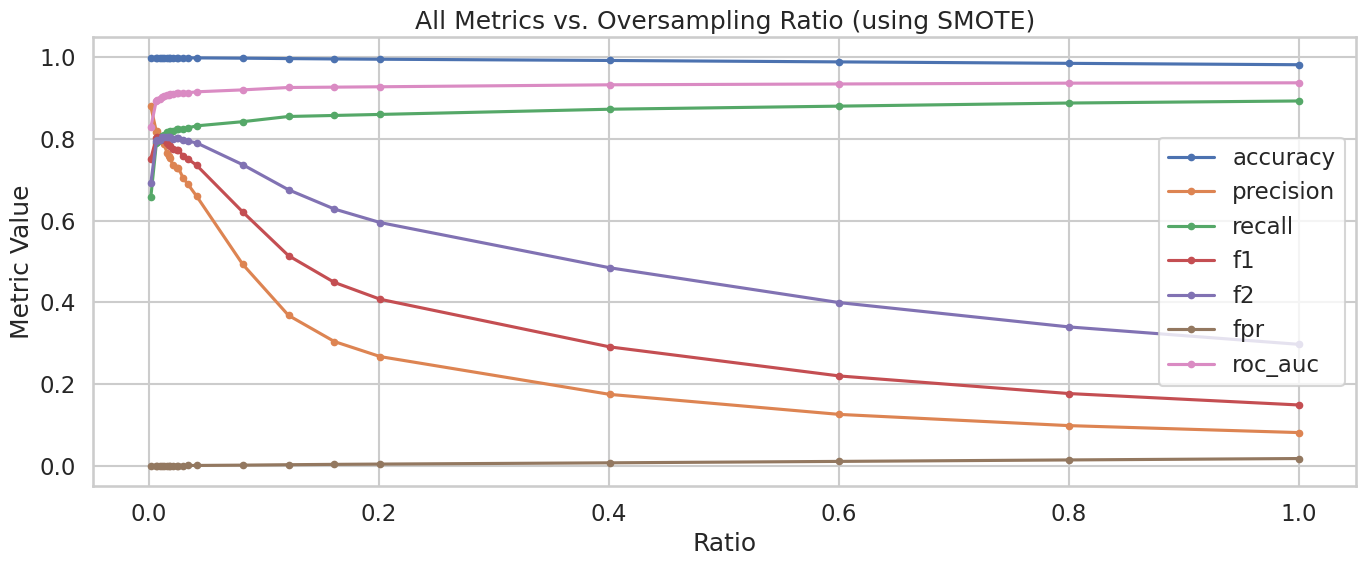

In [ ]:
sns.set(style="whitegrid", context="talk")

metrics = ["accuracy", "precision", "recall", "f1", "f2", "fpr", "roc_auc"]

plt.figure(figsize=(14, 6))

for metric in metrics:
    plt.plot(
          ratio_metrics_df["ratio"],
          ratio_metrics_df[metric],
          marker=".",
          label=metric
        )

plt.title("All Metrics vs. Oversampling Ratio (using SMOTE)")
plt.xlabel("Ratio")
plt.ylabel("Metric Value")
plt.legend()
plt.tight_layout()
plt.show()

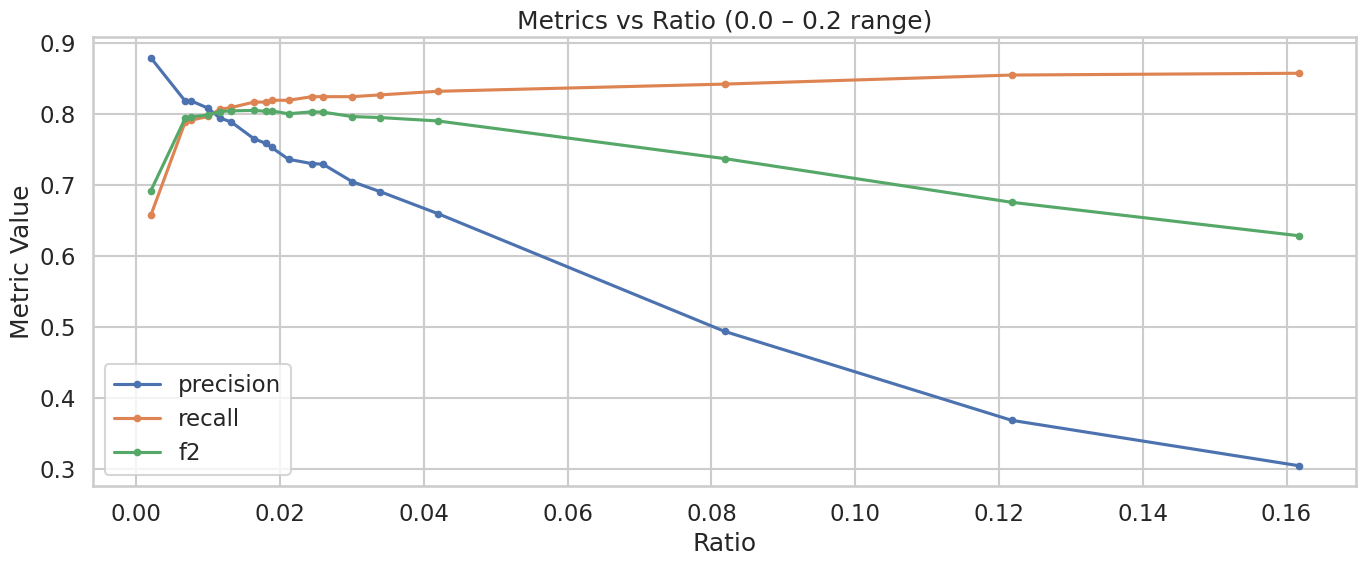

In [ ]:
focus = 0.2
sns.set(style="whitegrid", context="talk")
metrics = ["precision", "recall", "f2"]

ratio_focus_df = ratio_metrics_df[ratio_metrics_df["ratio"] <= focus].sort_values("ratio")

plt.figure(figsize=(14, 6))

for metric in metrics:
    plt.plot(
          ratio_focus_df["ratio"],
          ratio_focus_df[metric],
          marker=".",
          label=metric
        )

plt.title(f"Metrics vs Ratio (0.0 – {focus} range)")
plt.xlabel("Ratio")
plt.ylabel("Metric Value")
plt.legend()
plt.tight_layout()
plt.show()

##### 💎 **SUMMARY**

### 👽 Try training with `Gaussian Naive Bayes`

##### 👻 Using all PC as features for the model

In [ ]:
# define the k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# list of result of each fold
gnb_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# split the train_set, return fold_idx and train/val idx
for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
  # create train/val using idx
  X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
  y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

  # model definition, use the imbalanced dataset to calculate prior
  model = GaussianNB(
      priors=None,
  )

  model.fit(X=X_train_fold, y=y_train_fold)
  y_pred = model.predict(X_val_fold)

  # collect metrics
  # report = classification_report(y_val_fold, y_pred, output_dict=True)
  # cm = confusion_matrix(y_val_fold, y_pred)
  metrics = collect_metrics(y_val_fold, y_pred)

  # store metrics into dataframe
  gnb_results.loc[len(gnb_results)] = [idx] + metrics
  print(f"- Fold {idx} done")

- Fold 1 done
- Fold 2 done
- Fold 3 done
- Fold 4 done
- Fold 5 done


In [ ]:
gnb_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.979043,0.054271,0.794118,0.101599,0.213102,0.020681,0.886718
1,2.0,0.977353,0.051402,0.763889,0.096322,0.202504,0.022309,0.870790
2,3.0,0.977287,0.067334,0.880952,0.125106,0.257840,0.022535,0.929209
3,4.0,0.978231,0.065903,0.831325,0.122124,0.250181,0.021501,0.904912
4,5.0,0.977880,0.068416,0.839080,0.126516,0.257951,0.021855,0.908613


#### ◽ Try `Cluster Centroids` undersampling on the majority class

In [ ]:
# define k-fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# results container
gnb_results = pd.DataFrame(
    columns=[
        "idx",
        "accuracy",
        "precision",
        "recall",
        "f1",
        "f2",
        "fpr",
        "roc_auc"
    ]
)

# k-fold loop
for idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"~~~ Fold {idx}/{kf.n_splits} started!")

    # create train/val subsets
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # model with prior probabilities
    model = GaussianNB(
        priors=[1 - 0.001727, 0.001727]  # must be list, not dict
    )

    # undersampler
    sampler = RandomUnderSampler(
        random_state=42,
        sampling_strategy=0.015
    )

    # pipeline
    pipeline = Pipeline([
        ("undersampler", sampler),
        ("model", model)
    ])

    # train
    pipeline.fit(X_train_fold, y_train_fold)
    y_pred = pipeline.predict(X_val_fold)
    print(f"- Training done!")

    # collect metrics
    metrics = collect_metrics(y_val_fold, y_pred)
    print("- Metrics collecting done!")

    # store metrics
    gnb_results.loc[len(gnb_results)] = [idx] + metrics
    print(f"- Fold {idx} done!\n")

~~~ Fold 1/5 started!
- Training done!
- Metrics collecting done!
- Fold 1 done!

~~~ Fold 2/5 started!
- Training done!
- Metrics collecting done!
- Fold 2 done!

~~~ Fold 3/5 started!
- Training done!
- Metrics collecting done!
- Fold 3 done!

~~~ Fold 4/5 started!
- Training done!
- Metrics collecting done!
- Fold 4 done!

~~~ Fold 5/5 started!
- Training done!
- Metrics collecting done!
- Fold 5 done!



In [ ]:
gnb_results.head(100)

,idx,accuracy,precision,recall,f1,f2,fpr,roc_auc
0,1.0,0.976914,0.060469,0.858974,0.112985,0.235915,0.022884,0.918045
1,2.0,0.978428,0.060311,0.784810,0.112014,0.230655,0.021235,0.881787
2,3.0,0.977463,0.058659,0.797468,0.109280,0.226619,0.022225,0.887622
3,4.0,0.976892,0.065179,0.924051,0.121768,0.254178,0.023016,0.950517
4,5.0,0.977441,0.056956,0.772152,0.106087,0.219899,0.022203,0.874975


**NOTE**:

## ⚖️ FINAL EVALUATION



---



## 💀 RISKS AND LIMITATIONS



---



## 🔭 EXTENSION USING NEURAL NETWORK MODEL (OPTIONAL)





---



## 👍NOTES AND RULES OF THUMB

- Decision boundary for classification
- Don't ever experiment on the `test` set
- `Undersampling` and `Oversampling`
- `Threshold tuning`(as A `False Negative` is considered to be very dangerous)
- `Backward elimination`
- `Naive Bayes` (Gausian distribution)
- Have to understand `SMOTE` (or skip it)
- Using `Accuracy` metric, 99.8% accuracy before any model implementation
- Never mess up (touch) with your test set
- Model selection should not be just `try everything and pick the highest score`
- `Precision` and `FPR`: We could have low precision (lots of false alerts among alerts) but still a low number of total false alerts overall, if the system rarely flags anything
- Low precision = Our fraud alerts aren't very trustworthy. High FPR = Our fraud system bothers too many honest people
- Even if precision is low, the FPR might still be tiny, if model don't flag many legitimate transactions
- Resampling is not about forcing a perfect balance, it's about reducing the model's bias toward the majority class. You can experiment with different ratios and pick the one that optimizes your chosen metric on the validation set.
- Sampling techniques interact differently depending on the model.
- Almost every fraud detector adjusts the decision threshold.
- Your test set must remain completely untouched and unseen until the final evaluation. It should represent the original, real-world class distribution
- The test set should be completely untouched until the very final evaluation after all modeling decisions are made. Using it for the baseline evaluation, then trying other techniques, and then evaluating again on the same test set is a form of data leakage because you're using the test set to make decisions about which approach is better
- Use calibration plot



---



## 🙈 AUTHORS

-
-
-
- LE BUI TRUNG DUNG



---



In [ ]:
#1234789 đánh giá;  12345,10 chạy mô hình cuối cùng
# ==============================================================
# 1. Import thư viện
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.base import clone


# ==============================================================
# 2. Đọc dữ liệu và hiển thị thông tin dữ liệu
# ==============================================================
# df = pd.read_csv("/content/sample_data/creditcard.csv")
df = pd.read_csv("creditcard.csv")

print(df.head())
print(df.info())
print("\nTỷ lệ lớp (Class):")
print(df["Class"].value_counts(normalize=True))
print( df.describe())

# ==============================================================
# 3. Vẽ ma trận tương quan giữa các thuộc tính
# ==============================================================
# Tạo thư mục lưu hình ảnh
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(12,10))
corr = df.corr()

sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Ma trận tương quan giữa các thuộc tính")
plt.tight_layout()
plt.savefig("figures/correlation_matrix.png", dpi=150)
plt.close()

# ==============================================================
# 4. Chuẩn bị dữ liệu
# ==============================================================
X = df.drop(columns=["Class", "Time"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================================================
# 5. Áp dụng SMOTE để cân bằng dữ liệu cho việc đánh giá trên tập test
# ==============================================================
# Chuẩn hóa cột Amount, Comment lại khi đánh giá mô hình
# scaler = StandardScaler()
# X_train["Amount"] = scaler.fit_transform(X_train[["Amount"]])
# X_test["Amount"] = scaler.transform(X_test[["Amount"]])
#
# smote = SMOTE(sampling_strategy=0.2, random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
#
# print("\nPhân phối lớp trước và sau SMOTE:")
# print("Trước SMOTE:", np.bincount(y_train))
# print("Sau SMOTE:", np.bincount(y_train_res))

# ==============================================================
# 6. Vẽ phân phối của từng feature theo Class và sau SMOTE
# ==============================================================
# features = [c for c in df.columns if c not in ["Class", "Time"]]
#
# # Tạo DataFrame sau SMOTE để trực quan
# X_smote_df = pd.DataFrame(X_train_res, columns=X.columns)
# X_smote_df["Class"] = y_train_res.values
#
# for col in features:
#     plt.figure(figsize=(6, 4))
#     # Phân phối gốc
#     sns.kdeplot(data=df[df["Class"] == 0], x=col, label="Class 0 (gốc)", fill=True, alpha=0.4)
#     sns.kdeplot(data=df[df["Class"] == 1], x=col, label="Class 1 (gốc)", fill=True, alpha=0.4, color="r")
#
#     # Phân phối sau SMOTE
#     sns.kdeplot(
#     data=X_smote_df[X_smote_df["Class"] == 1],
#     x=col, label="Class 1 (sau SMOTE)", fill=False, color="green", linestyle="--"
#     )
#
#     plt.title(f"Phân phối đặc trưng {col}\n(Class 0, Class 1 gốc, Class 1 sau SMOTE)")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f"figures/feature_distribution_{col}_with_smote.png", dpi=150)
#     plt.close()

# ==============================================================
# 7. Hàm đánh giá mô hình bằng K-Fold (trả về trung bình các metrics)
# ==============================================================

def evaluate_model_kfold(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} không smote =====")

    # Thiết lập tham số mô hình
    model = clone(model)
    model.set_params(**params)
    # model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Train
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": f"{model_name} {params}",
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


def evaluate_model_kfold_smote(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} có smote =====")

    # Thiết lập tham số mô hình
    model = clone(model)
    model.set_params(**params)
    # model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    smote = SMOTE(sampling_strategy=0.2, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Cân bằng dữ liệu bằng SMOTE
        X_res, y_res = smote.fit_resample(X_train, y_train)

        # Train
        model.fit(X_res, y_res)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": f"{model_name} {params}",
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


# ==============================================================
# 8. Danh sách mô hình và bộ tham số cần thử nghiệm
# ==============================================================
model_configs = [
    # Logistic Regression
    (
        LogisticRegression(random_state=42, max_iter=1000),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # Random Forest
    (
        RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # SVC
    (
        SVC(probability=True, random_state=42),
        [
            {"kernel": "rbf"},
            # {"kernel": "poly"},
            # {"kernel": "linear"},
            # {"class_weight": "balanced", "kernel": "poly"},
        ]
    )
]


# ==============================================================
# 9. Chạy đánh giá
# ==============================================================
results = []
for model, param_list in model_configs:
    for params in param_list:
        model_name = repr(model)
        # result = evaluate_model_kfold(model, params, X_train, y_train, model_name, k=4)
        result = evaluate_model_kfold_smote(model, params, X_train, y_train, model_name, k=4)
        results.append(result)

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score", ascending=False, inplace=True)

print("\n===== KẾT QUẢ TỔNG HỢP =====")
print(results_df)
# ======= Xuất ra file CSV =======
results_df.to_csv("figures/results.csv", index=False, encoding="utf-8-sig")

# ==============================================================
# 10. Huấn luyện mô hình chạy trên tập test
# ==============================================================
# model = RandomForestClassifier(
#     n_estimators=200,
#     random_state=42,
#     n_jobs=-1,
#     # class_weight="balanced_subsample"
# )
#
# # # No SMOTE
# model.fit(X_train, y_train)
# # # SMOTE
# # # model.fit(X_train_res, y_train_res)
# #
# # Dự đoán
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]
#
# # Đánh giá
# # Tạo confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# labels = ["Class 0 (Normal)", "Class 1 (Fraud)"]
#
# # Vẽ biểu đồ heatmap
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.tight_layout()
# plt.savefig("figures/confusion_matrix.png", dpi=150)
#
# print("\nConfusion Matrix:\n", cm)
# print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
# print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# # ==============================================================
# # 8. Vẽ feature importance
# # ==============================================================
# importances = model.feature_importances_
# feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
# plt.figure(figsize=(8,6))
# sns.barplot(x=feat_imp[:], y=feat_imp.index[:])
# plt.title("Top 10 Feature Importance (RandomForest)")
# plt.tight_layout()
# plt.savefig("figures/feature_importance.png", dpi=150)
# plt.close()



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 